In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import sys
sys.path.append("/home/yufan") 
#from perturbgene.data_utils import GeneTokenizer, read_h5ad_file
import scanpy as sc
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import pandas as pd
import glob
import re

In [2]:
adata = sc.read_h5ad("chunk3562_stress_tumor_repair2.h5ad")
adata

/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 10000 × 58604
    obs: 'soma_joinid_column', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch', 'GDF15_embedding_status', 'NPY_embedding_status', 'TFPI2_embedding_status', 'MEG3_embedding_status', 'WIF1_embedding_status', 'HACE1_embedding_status', 'SGK1_embedding_status', 'LRRC3B_embedding_status', 'MKRN1_embedding_status', 'THY1_embedding_status', 'LZTFL1_embedding_status', 'DUSP26_embedding_status', 'TMEFF2_embedding_status', 'PAX1_embedding_status', 'CXXC4_embedding_status', 'MXI1_embedding_s

In [3]:
def label_to_float(label):
    label = label.replace("_"," ").replace("-",' ')
    if 'year' in label:
        if "-" in label:
            return float(label.split(' ')[0])
        elif label == "under 1 year old human stage":
            return 1.0
        else:
            return float(label.split(' ')[0])
    elif 'month' in label:
        # Convert month to weeks (approximate)
        if "LMP" not in label:
            return float(label.split(' ')[0])/12
        elif label == "eighth LMP month human stage":
            return 8/12
        elif label == "fifth LMP month human stage":
            return 5/12
        # Add more cases as needed
    elif 'week' in label:
        return float(label.split(" ")[0].replace("th",'').replace("st",""))/52
    return -1.0

### Figure 2: Age Prediction vs chronological age label

In [20]:
def plot_z_score(y_test,y_pred, fig_name = "plots/age_prediction_z_score.png"):
    # Calculate Pearson correlation
    r, _ = pearsonr(y_test, y_pred)
    print(f'Pearson correlation (r): {r:.2f}')

    # Calculate the z-scored age gap - (age gap - mean of age gap)/sd of age gap
    age_gap = y_pred - y_test
    mean_age_gap = np.mean(age_gap)
    std_age_gap = np.std(age_gap)
    z_scored_age_gap = (age_gap - mean_age_gap) / std_age_gap

    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, hue=z_scored_age_gap, palette='coolwarm', edgecolor='k', alpha=0.6, legend=False)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    norm = plt.Normalize(z_scored_age_gap.min(), z_scored_age_gap.max())
    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='z-scored age gap')
    plt.xlabel('chronological age',fontsize=18)
    plt.ylabel('predicted age',fontsize=18)
    plt.title(f'age prediction',fontsize=18)
    plt.text(0.05, 0.95, f'r = {r:.2f}', transform=plt.gca().transAxes, 
            fontsize=18, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black"))
    plt.savefig(fig_name, dpi=300, bbox_inches='tight') 
    plt.show()

Pearson correlation (r): 0.96


/tmp/ipykernel_11513/634496731.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='z-scored age gap')


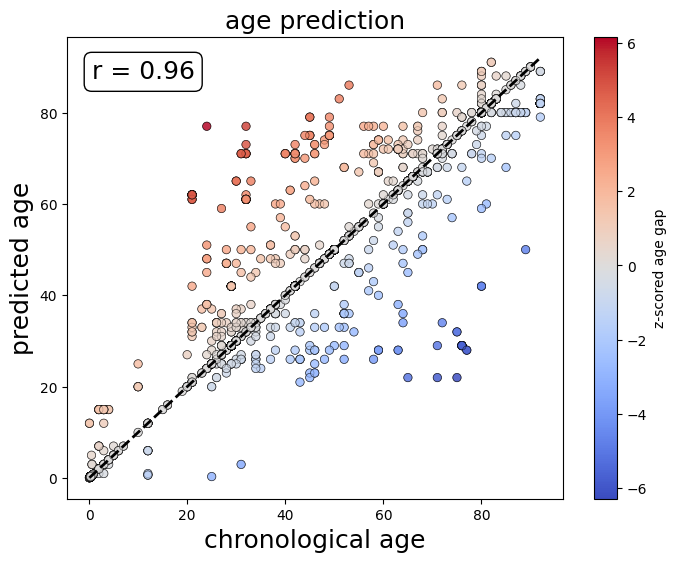

In [21]:
adata_cut = adata[adata.obs["disease"] == "normal"]
ground_truth = adata_cut.obs["development_stage"].apply(label_to_float).to_list()
prediction = adata_cut.obs["prediction_age"].apply(label_to_float).to_list()
y_test, y_pred = zip(*[(x, y) for x, y in zip(ground_truth, prediction) if x != -1.0 and y != -1.0])
y_test = np.array(list(y_test))
y_pred = np.array(list(y_pred))

plot_z_score(y_test, y_pred)

Pearson correlation (r): 0.98


/tmp/ipykernel_11513/634496731.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='z-scored age gap')


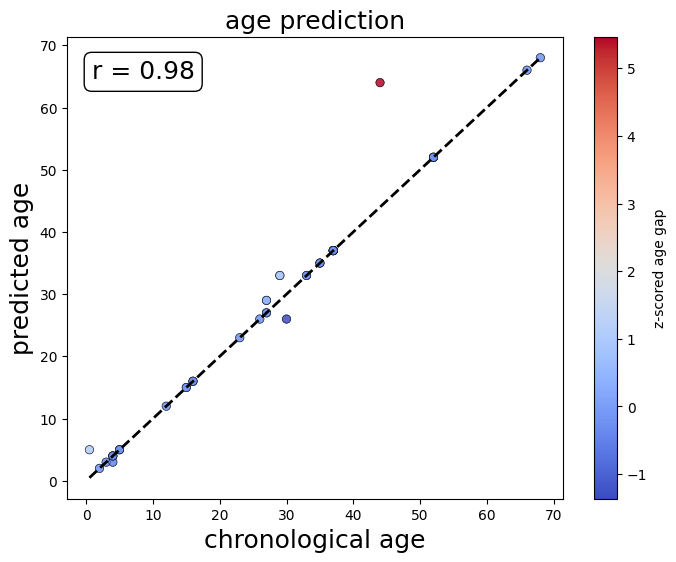

In [23]:
tissue = "respiratory airway"
adata_cut = adata[(adata.obs["disease"] == "normal") & (adata.obs["tissue"] == tissue)]
ground_truth = adata_cut.obs["development_stage"].apply(label_to_float).to_list()
prediction = adata_cut.obs["prediction_age"].apply(label_to_float).to_list()
y_test, y_pred = zip(*[(x, y) for x, y in zip(ground_truth, prediction) if x != -1.0 and y != -1.0])
y_test = np.array(list(y_test))
y_pred = np.array(list(y_pred))

plot_z_score(y_test, y_pred, f"plots/{tissue}_age_prediction_z_score.png")

Pearson correlation (r): 0.62


/tmp/ipykernel_11513/634496731.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='z-scored age gap')


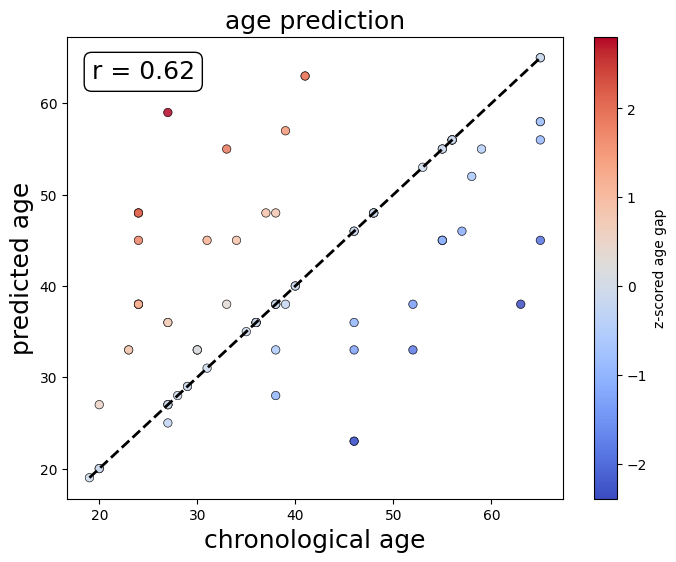

In [24]:
tissue = "breast"
adata_cut = adata[(adata.obs["disease"] == "normal") & (adata.obs["tissue"] == tissue)]
ground_truth = adata_cut.obs["development_stage"].apply(label_to_float).to_list()
prediction = adata_cut.obs["prediction_age"].apply(label_to_float).to_list()
y_test, y_pred = zip(*[(x, y) for x, y in zip(ground_truth, prediction) if x != -1.0 and y != -1.0])
y_test = np.array(list(y_test))
y_pred = np.array(list(y_pred))

plot_z_score(y_test, y_pred, f"plots/{tissue}_age_prediction_z_score.png")

### Fig 3: cell-type-specific age predictions

In [4]:
adata_cut = adata[adata.obs["disease"] == "normal"]
data = pd.DataFrame({
    'Predicted Age': adata_cut.obs["prediction_age"].apply(label_to_float).to_list(),
    'Ground Truth Age': adata_cut.obs["development_stage"].apply(label_to_float).to_list(),
    'Cell Type': adata_cut.obs["cell_type"].to_list()
})

# Filter out invalid values
data = data[(data['Predicted Age'] != -1) & (data['Ground Truth Age'] != -1)]
unique_cell_types = data['Cell Type'].unique()
for cell_type in unique_cell_types:
    subset = data[data['Cell Type'] == cell_type]
    if len(subset) > 10:  # Filter for sufficient data
        plt.figure(figsize=(12, 8))
        sns.regplot(x="Ground Truth Age", y="Predicted Age", data=subset, ci=None, scatter_kws={"s": 20, "color": "blue"}, line_kws={"color": "black"})
        
        # Calculate correlation
        correlation = subset.corr().loc["Ground Truth Age", "Predicted Age"]
        if pd.notna(correlation):
            plt.text(0.1, 0.9, f'R = {correlation:.2f}', transform=plt.gca().transAxes, fontsize=18, verticalalignment='top')
        
        # Set labels and titles
        plt.xlabel("Chronological age",fontsize=18)
        plt.ylabel("Predicted chronological age",fontsize=18)
        plt.title(f'Age Prediction vs Ground Truth for Cell Type: {cell_type}',fontsize=18)
        output_dir = "cell_type"
        # Save plot
        plt.savefig(os.path.join(output_dir, f'{cell_type.replace(" ","_").replace("/","_")}_plot.png'), bbox_inches='tight')
        plt.close()

/tmp/ipykernel_61792/2189127356.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = subset.corr().loc["Ground Truth Age", "Predicted Age"]


/tmp/ipykernel_61792/3763033040.py:31: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = subset.corr().loc["Ground Truth Age", "Predicted Age"]


<Figure size 1200x800 with 0 Axes>

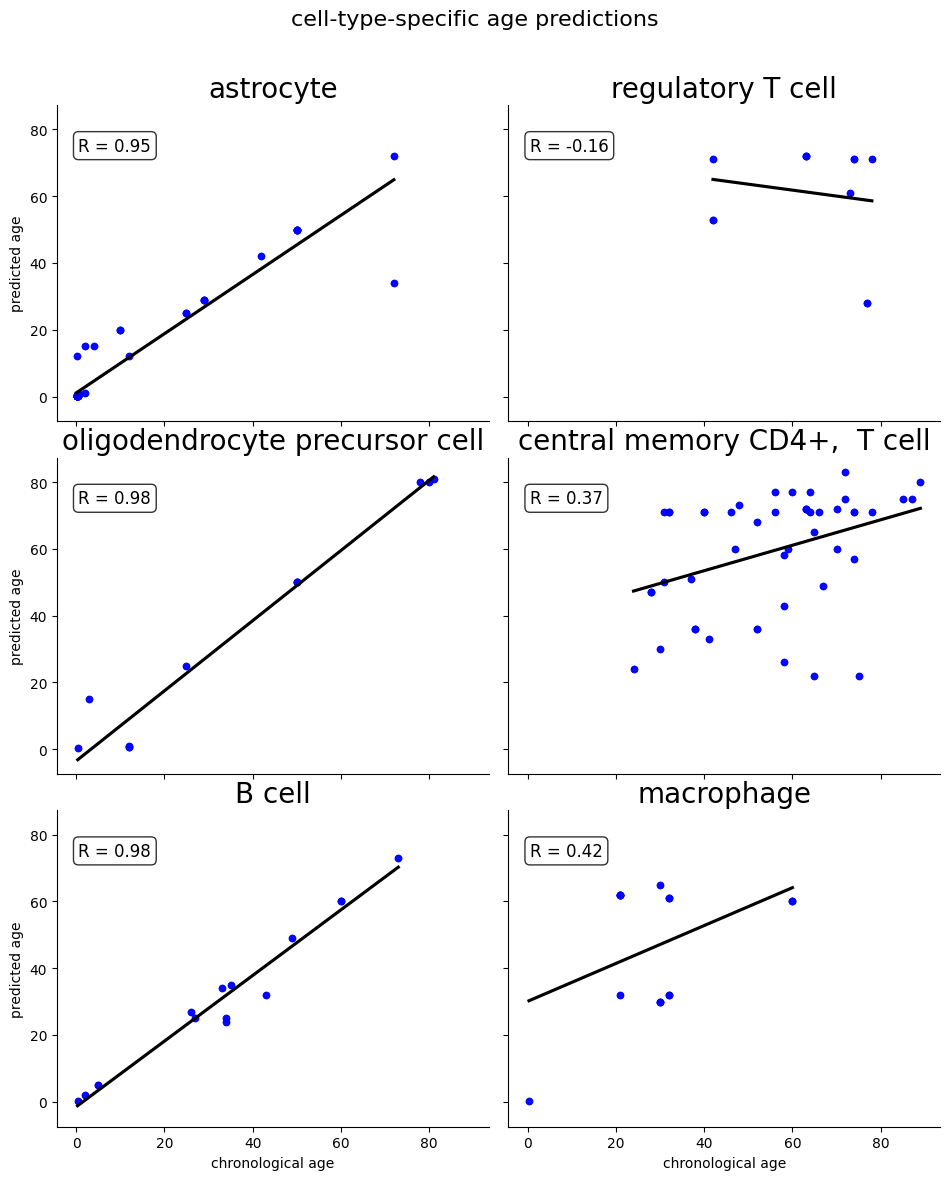

In [5]:
adata_cut = adata[adata.obs["disease"] == "normal"]
data = pd.DataFrame({
    'Predicted Age': adata_cut.obs["prediction_age"].apply(label_to_float).to_list(),
    'Ground Truth Age': adata_cut.obs["development_stage"].apply(label_to_float).to_list(),
    'Cell Type': adata_cut.obs["cell_type"].to_list()
})
data = data[(data['Predicted Age'] != -1) & (data['Ground Truth Age'] != -1)]
valid_cell_types = ['astrocyte','regulatory T cell','oligodendrocyte precursor cell',
                    'central memory CD4-positive, alpha-beta T cell',
                    'B cell','macrophage']
filtered_data = data[data['Cell Type'].isin(valid_cell_types)]


# plot
plt.figure(figsize=(12, 8))
g = sns.FacetGrid(filtered_data, col="Cell Type", col_wrap=2, height=4, aspect=1.2, col_order=valid_cell_types)
g.map(
    sns.regplot, 
    "Ground Truth Age", 
    "Predicted Age", 
    ci=None, 
    scatter_kws={"s": 20, "color": "blue"}, 
    line_kws={"color": "black"}
)
for ax in g.axes.flat:
    title = ax.get_title()
    cell_type = title.split(" = ")[-1] 
    formatted_title = cell_type.replace("-positive", "+").replace("alpha-beta",'') # rename to make it shorter for this cell type
    ax.set_title(formatted_title, fontsize=20)
    subset = filtered_data[filtered_data["Cell Type"] == cell_type]
    correlation = subset.corr().loc["Ground Truth Age", "Predicted Age"]
    if pd.notna(correlation):
        ax.text(
            0.05, 0.9, 
            f'R = {correlation:.2f}', 
            transform=ax.transAxes, 
            fontsize=12, 
            verticalalignment='top', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black", alpha=0.8), 
            color="black"
        )
g.set_axis_labels("chronological age", "predicted age")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("cell-type-specific age predictions", fontsize=16)
plt.savefig("plots/cell-type-specific age predictions.png", dpi=300, bbox_inches='tight')
plt.show()

### Figure 4: Similarity between cell type token and age token

In [16]:
cosine_similarity_dict = {}
adata_cut = adata[adata.obs["disease"] == "normal"]
embedding_1 = adata_cut.obsm["cell_type_embeddings"]
embedding_2 = adata_cut.obsm["development_stage_embeddings"]
cell_types = adata_cut.obs["cell_type"]

# calculate cosine similiarity group by cell types
for cell_type in cell_types.unique():
    cell_indices = adata_cut.obs["cell_type"] == cell_type
    subset_embedding_1 = embedding_1[cell_indices]
    subset_embedding_2 = embedding_2[cell_indices]
    similarity_matrix = cosine_similarity(subset_embedding_1, subset_embedding_2)
    cosine_similarity_dict[cell_type] = np.diag(similarity_matrix)

/tmp/ipykernel_174690/3376693162.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cell type', y='cosine similarity', data=df, palette="magma_r")


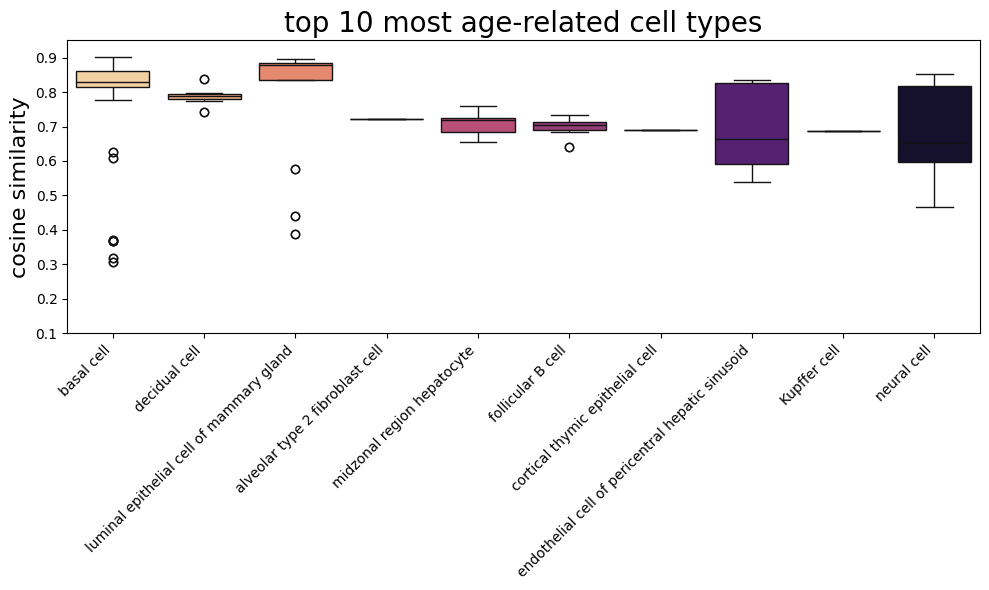

In [22]:
top10 = sorted(cosine_similarity_dict.items(), key=lambda x: np.mean(x[1]), reverse=True)[:10]
plot_data = {
    'cell type': [],
    'cosine similarity': []
}
for cell_type, cosine_similarity_values in top10:
    plot_data['cell type'].extend([cell_type] * len(cosine_similarity_values))
    plot_data['cosine similarity'].extend(cosine_similarity_values)
df = pd.DataFrame(plot_data)
#df.to_csv("mean_top10age-celltype.csv")

plt.figure(figsize=(10, 6))
sns.boxplot(x='cell type', y='cosine similarity', data=df, palette="magma_r")
plt.xticks(rotation=45, ha='right')
plt.ylim(0.1, 0.95)
plt.title('top 10 most age-related cell types',fontsize=20)
plt.xlabel('', fontsize=16)
plt.ylabel('cosine similarity', fontsize=16)
plt.tight_layout()
plt.savefig("plots/mean_top10_most age-related cell types.png", dpi=300, bbox_inches='tight')

/tmp/ipykernel_174690/847789566.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cell type', y='cosine similarity', data=df, palette="magma")


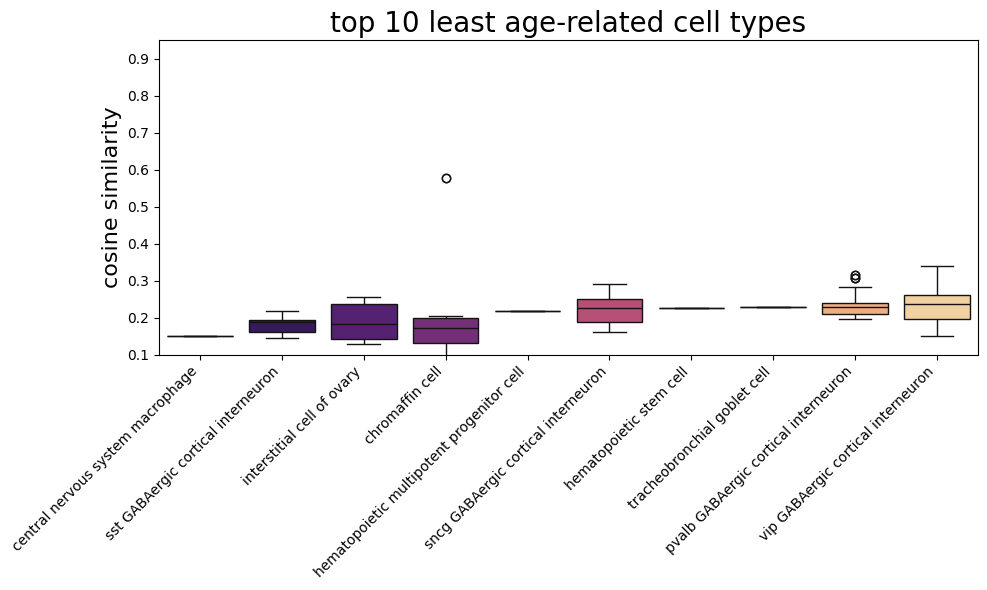

In [23]:
top10 = sorted(cosine_similarity_dict.items(), key=lambda x: np.mean(x[1]))[:10]
plot_data = {
    'cell type': [],
    'cosine similarity': []
}
for cell_type, cosine_similarity_values in top10:
    plot_data['cell type'].extend([cell_type] * len(cosine_similarity_values))
    plot_data['cosine similarity'].extend(cosine_similarity_values)
df = pd.DataFrame(plot_data)
#df.to_csv("mean_last10age-celltype.csv")

plt.figure(figsize=(10, 6))
sns.boxplot(x='cell type', y='cosine similarity', data=df, palette="magma")
plt.xticks(rotation=45, ha='right')
plt.ylim(0.1, 0.95)
plt.xlabel('', fontsize=16)
plt.ylabel('cosine similarity', fontsize=16)
plt.title('top 10 least age-related cell types',fontsize=20)
plt.tight_layout()
plt.savefig("plots/mean_top10_least age-related cell types.png", dpi=300, bbox_inches='tight')

### Fig 5: Dynamics of changes in aging using z-scored age gap

In [6]:
ground_truth = [label_to_float(label) for label in adata.obs["development_stage"]]
predictions = [label_to_float(label) for label in adata.obs["prediction_age"]]

df = pd.DataFrame({
    'Ground Truth': ground_truth,
    'Prediction': predictions
})

df = df[df['Prediction'] != -1]
df['Age Gap'] = df['Prediction'] - df['Ground Truth']
df = df[df['Age Gap'] != 0]
mean_gap = df['Age Gap'].mean()
std_gap = df['Age Gap'].std()
df['Z-Score'] = (df['Age Gap'] - mean_gap) / std_gap

/tmp/ipykernel_174690/1395907410.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Age Gap Range', y='Z-Score', data=df, scale='width', inner='quartile',palette="viridis_r")
/tmp/ipykernel_174690/1395907410.py:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Age Gap Range', y='Z-Score', data=df, scale='width', inner='quartile',palette="viridis_r")


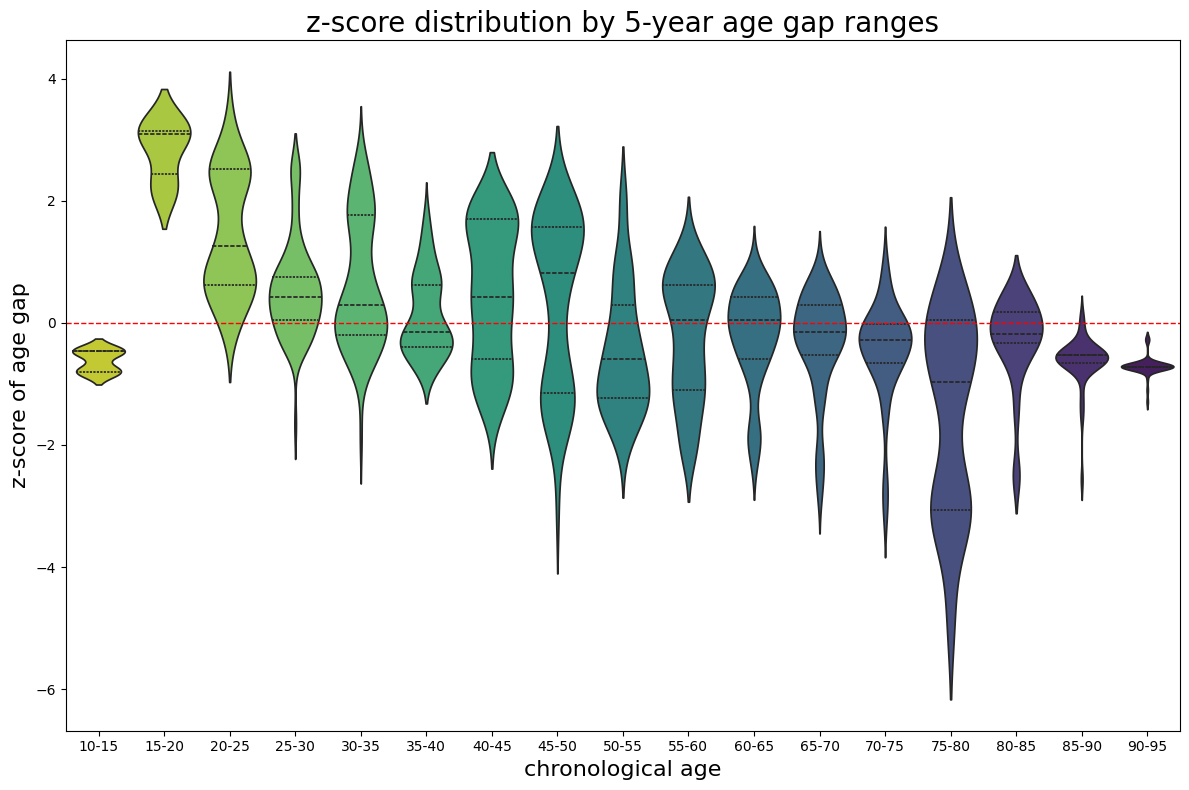

In [15]:
bins = range(10, 100, 5)  # 0-5, 5-10, ..., 95-100
labels = [f"{i}-{i+5}" for i in bins[:-1]]
df = df[df["Ground Truth"] > 10]
df['Age Gap Range'] = pd.cut(df['Ground Truth'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(12, 8))
sns.violinplot(x='Age Gap Range', y='Z-Score', data=df, scale='width', inner='quartile',palette="viridis_r")
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('z-score distribution by 5-year age gap ranges',fontsize=20)
plt.xlabel('chronological age',fontsize=16)
plt.ylabel('z-score of age gap',fontsize=16)
plt.tight_layout()
plt.savefig("plots/z_score_5year_gap.png", dpi=300, bbox_inches='tight')

### Fig 6: Tissue-dependent and cell-type-specific aging dynamics

In [3]:
age_label_mapping_10 = {'1-month-old human stage':"unknown",
 '1-year-old human stage':"unknown",
 '10-month-old human stage':"unknown",
 '10-year-old human stage':"10-20",
 '10th week post-fertilization human stage':"unknown",
 '11-month-old human stage':"unknown",
 '12-year-old human stage':"10-20",
 '12-month-old human stage':'unknown',
 '12th week post-fertilization human stage':"unknown",
 '13th week post-fertilization human stage':"unknown",
 '14th week post-fertilization human stage':"unknown",
 '14-year-old human stage':"10-20",
 '15-year-old human stage':"10-20",
 '15th week post-fertilization human stage':"unknown",
 '16-year-old human stage':"10-20",
 '16th week post-fertilization human stage':"unknown",
 '17-year-old human stage':"10-20",
 '17th week post-fertilization human stage':"unknown",
 '18th week post-fertilization human stage':"unknown",
 '19-year-old human stage':"10-20",
 '19th week post-fertilization human stage':"unknown",
 '2-5 year-old child stage':"unknown",
 '2-month-old human stage':"unknown",
 '2-year-old human stage':"unknown",
 '20-year-old human stage':"20-30",
 '20th week post-fertilization human stage':"unknown",
 '21-year-old human stage':"20-30",
 '22-year-old human stage':"20-30",
 '23-year-old human stage':"20-30",
 '24-year-old human stage':"20-30",
 '25-year-old human stage':"20-30",
 '25th week post-fertilization human stage':"unknown",
 '26-year-old human stage':"20-30",
 '27-year-old human stage':"20-30",
 '28-year-old human stage':"20-30",
 '29-year-old human stage':"20-30",
 '3-month-old human stage':"unknown",
 '3-year-old human stage':"unknown",
 '30-year-old human stage':"20-30",
 '31-year-old human stage':"30-40",
 '31st week post-fertilization human stage':"unknown",
 '32-year-old human stage':"30-40",
 '33-year-old human stage':"30-40",
 '34-year-old human stage':"30-40",
 '35-year-old human stage':"30-40",
 '36-year-old human stage':"30-40",
 '37-year-old human stage':"30-40",
 '38-year-old human stage':"30-40",
 '39-year-old human stage':"30-40",
 '4-month-old human stage':"unknown",
 '4-year-old human stage':"unknown",
 '40-year-old human stage':"40-50",
 '41-year-old human stage':"40-50",
 '42-year-old human stage':"40-50",
 '43-year-old human stage':"40-50",
 '44-year-old human stage':"40-50",
 '45-year-old human stage':"40-50",
 '46-year-old human stage':"40-50",
 '47-year-old human stage':"40-50",
 '48-year-old human stage':"40-50",
 '49-year-old human stage':"40-50",
 '5-year-old human stage':"unknown",
 '50-year-old human stage':"40-50",
 '51-year-old human stage':"50-60",
 '52-year-old human stage':"50-60",
 '53-year-old human stage':"50-60",
 '54-year-old human stage':"50-60",
 '55-year-old human stage':"50-60",
 '56-year-old human stage':"50-60",
 '57-year-old human stage':"50-60",
 '58-year-old human stage':"50-60",
 '59-year-old human stage':"50-60",
 '6-12 year-old child stage':"unknown",
 '6-month-old human stage':"unknown",
 '6-year-old human stage':"unknown",
 '60-year-old human stage':"60-70",
 '61-year-old human stage':"60-70",
 '62-year-old human stage':"60-70",
 '63-year-old human stage':"60-70",
 '64-year-old human stage':"60-70",
 '65-year-old human stage':"60-70",
 '66-year-old human stage':"60-70",
 '67-year-old human stage':"60-70",
 '68-year-old human stage':"60-70",
 '69-year-old human stage':"60-70",
 '7-month-old human stage':"unknown",
 '7-year-old human stage':"unknown",
 '70-year-old human stage':"60-70",
 '71-year-old human stage':"70-80",
 '72-year-old human stage':"70-80",
 '73-year-old human stage':"70-80",
 '74-year-old human stage':"70-80",
 '75-year-old human stage':"70-80",
 '76-year-old human stage':"70-80",
 '77-year-old human stage':"70-80",
 '78-year-old human stage':"70-80",
 '79-year-old human stage':"70-80",
 '8-year-old human stage':"unknown",
 '80 year-old and over human stage':">80",
 '80-year-old human stage':">80",
 '81-year-old human stage':">80",
 '82-year-old human stage':">80",
 '83-year-old human stage':">80",
 '84-year-old human stage':">80",
 '85-year-old human stage':">80",
 '86-year-old human stage':">80",
 '87-year-old human stage':">80",
 '88-year-old human stage':">80",
 '89-year-old human stage':">80",
 '9-month-old human stage':"unknown",
 '9-year-old human stage':"unknown",
 '90-year-old human stage':">80",
  '91-year-old human stage':">80",
 '92-year-old human stage':">80",
  '93-year-old human stage':">80",
 '9th week post-fertilization human stage':"unknown",
 'Carnegie stage 17':"unknown",
 'Carnegie stage 18':"unknown",
 'Carnegie stage 20':"unknown",
 'Carnegie stage 22':"unknown",
 'Carnegie stage 23':"unknown",
 'adolescent stage':"unknown",
 'eighth LMP month human stage':"unknown",
 'eighth decade human stage':">80",
 'embryonic human stage':"unknown",
 'fifth LMP month human stage':"unknown",
 'fifth decade human stage':"50-60",
 'fourth decade human stage':"40-50",
 'human adult stage':"unknown",
 'human aged stage':"unknown",
 'infant stage':"unknown",
 'mature stage':"unknown",
 'newborn human stage':"unknown",
 'ninth decade human stage':">80",
 'organogenesis stage':"unknown",
 'seventh decade human stage':"70-80",
 'sixth decade human stage':"60-70",
 'third decade human stage':"30-40",
 'unknown':"unknown",
 'young adult stage':"unknown"}

In [ ]:
def top3genes_by_age(tissue, age_mapping=age_label_mapping_10, threshold=0.01, top_n=3):
    #count number of samples for each age stage
    age_count = {}

    files = glob.glob(f"general_tissue_{tissue}_genes_by_age/{tissue}_chunk*_by_age.pkl")

    chunk_numbers = []
    pattern = re.compile(rf"{tissue}_chunk(\d+)(?:_cells_\d+_\d+)?_by_age\.pkl")

    for file in files:
        match = pattern.search(file)
        if match:
            # Append the chunk number to the list
            chunk_numbers.append(int(match.group(1)))
    
    for chunk in chunk_numbers:
        validation_data = sc.read_h5ad(f"/storage_bizon/sabrant_rocket_2tb/farhan/cellxgene/primary/cxg_chunk{chunk}.h5ad")
        validation_data.obs["age_group"] = validation_data.obs["development_stage"].map(age_mapping)
        filtered_data = validation_data[((validation_data.obs['cell_type'] == tissue)|
                                         (validation_data.obs['tissue_general'] == tissue)
                                         ) & (validation_data.obs["disease"] == "normal")]
        chunk_age_counts = filtered_data.obs["age_group"].value_counts()
        for age_group, count in chunk_age_counts.items():
            if age_group in age_count:
                age_count[age_group] += count
            else:
                age_count[age_group] = count

    #load data
    folder_path = f"general_tissue_{tissue}_genes_by_age"
    files = glob.glob(f"{folder_path}/{tissue}_chunk*_by_age.pkl")

    # Dictionary to store combined cosine similarities
    gene_cos_sim_by_age = {}
    print(files)
    # Load each file and update the main dictionary
    for file in files:
        try:
            with open(file, "rb") as f:
                print(file, "loaded")
                chunk_data = pickle.load(f)
                gene_cos_sim_by_age.update(chunk_data)
        except EOFError:
            print(f"Warning: Could not load {file} (file may be empty or corrupted)")
            """
    for i in range(3562, 3575):
        path2sim = f"{tissue}_genes_by_age/{tissue}_chunk{i}_by_age.pkl" 
        with open(path2sim, "rb") as f:
            chunk_data = pickle.load(f)
            print(path2sim, "loaded")
            gene_cos_sim_by_age.update(chunk_data)
"""

    #compute top 3 genes for each age stage, genes must express in > 1% of all samples
    data = []
    for gene, age_groups in gene_cos_sim_by_age.items():
        for age_group, values in age_groups.items():
            mapped_age_group = age_mapping.get(age_group, age_group)
            if mapped_age_group in age_count:
                if len(values) >= threshold * age_count[mapped_age_group]:
                    mean_cos_sim = sum(values) / len(values)
                    data.append([gene, mapped_age_group, mean_cos_sim])
    df = pd.DataFrame(data, columns=['Gene', 'Age Group', 'Mean Cosine Similarity'])
    top_genes_by_age_group = df.groupby('Age Group').apply(lambda x: x.nlargest(top_n, 'Mean Cosine Similarity')).reset_index(drop=True)
    return (
        top_genes_by_age_group[top_genes_by_age_group["Age Group"] != 'unknown']
        .groupby("Age Group")["Gene"]
        .apply(list)
        .to_dict()
    )

In [30]:
def top3genes_by_age(tissue, age_mapping=age_label_mapping_10, threshold=0.01, top_n=3):
    # Count the number of samples for each age stage
    age_count = {}
    files = glob.glob(f"general_tissue_{tissue}_genes_by_age/{tissue}_chunk*_by_age.pkl")
    chunk_numbers = []
    pattern = re.compile(rf"{tissue}_chunk(\d+)(?:_cells_\d+_\d+)?_by_age\.pkl")

    for file in files:
        match = pattern.search(file)
        if match:
            chunk_numbers.append(int(match.group(1)))

    chunk_numbers.sort()  # Ensure chunks are processed in order
    chunk_numbers = set(chunk_numbers)
    #print(f'for {tissue}: {chunk_numbers}')

    # Count the number of cells per age group
    for chunk in chunk_numbers:
        validation_data = sc.read_h5ad(f"/storage_bizon/sabrant_rocket_2tb/farhan/cellxgene/primary/cxg_chunk{chunk}.h5ad")
        validation_data.obs["age_group"] = validation_data.obs["development_stage"].map(age_mapping)
        filtered_data = validation_data[((validation_data.obs['cell_type'] == tissue) |
                                         (validation_data.obs['tissue_general'] == tissue))
                                         & (validation_data.obs["disease"] == "normal")]
        chunk_age_counts = filtered_data.obs["age_group"].value_counts()
        for age_group, count in chunk_age_counts.items():
            age_count[age_group] = age_count.get(age_group, 0) + count
    
    # Load cosine similarity data
    gene_cos_sim_by_age = {}
    for file in files:
        try:
            with open(file, "rb") as f:
                chunk_data = pickle.load(f)
                gene_cos_sim_by_age.update(chunk_data)
        except EOFError:
            print(f"Warning: Could not load {file} (file may be empty or corrupted)")
            continue

    # Compute top 3 genes for each age group
    data = []
    for gene, age_groups in gene_cos_sim_by_age.items():
        for age_group, values in age_groups.items():
            mapped_age_group = age_mapping.get(age_group, age_group)
            if mapped_age_group in age_count and age_count[mapped_age_group] > 0:
                if len(values) >= threshold * age_count[mapped_age_group]:
                    mean_cos_sim = sum(values) / len(values)
                    data.append([gene, mapped_age_group, mean_cos_sim])
    
    df = pd.DataFrame(data, columns=['Gene', 'Age Group', 'Mean Cosine Similarity'])
    top_genes_by_age_group = df.groupby('Age Group').apply(lambda x: x.nlargest(top_n, 'Mean Cosine Similarity')).reset_index(drop=True)
    
    # Return the top genes as a dictionary
    return (
        top_genes_by_age_group[top_genes_by_age_group["Age Group"] != 'unknown']
        .groupby("Age Group")["Gene"]
        .apply(list)
        .to_dict(), chunk_numbers
    )


In [15]:
tissue_top3genes = {}
threshold = 0.01
for tissue in ['liver', 'heart','lung', 'kidney',  'bone marrow', 'breast','blood',"brain"]:
    tissue_top3genes[tissue] = top3genes_by_age(tissue, threshold=threshold)
tissue_top3genes

/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Tran

{'liver': {'20-30': ['PIK3R5', 'FUT8', 'RP11-846F4.11'],
  '60-70': ['RPS12', 'CH17-258A22.4', 'KCNC3'],
  '>80': ['RNA5SP352', 'RP11-565O12.1', 'SAMD13']},
 'heart': {'30-40': ['RP11-403E24.1', 'U8_ENSG00000201810', 'MIR4263'],
  '40-50': ['KIR3DP1', 'MIR4667', 'RAP1A'],
  '50-60': ['CH507-39O4.2', 'MIR4303', 'AF254982.2'],
  '60-70': ['MIR6861', 'FZD2', 'KRT16P1'],
  '70-80': ['RP11-394I13.2', 'RP11-756J15.3', 'LINC02599'],
  '>80': ['AC004381.7', 'SPTB', 'RP11-536C12.1']},
 'lung': {'10-20': ['VN1R105P', 'RNU6-1039P', 'MICF'],
  '20-30': ['RPSAP4', 'RPS12', 'RPS12'],
  '30-40': ['RNU7-75P', 'RP11-404G16.2', 'ACTG1P11'],
  '40-50': ['RP11-394I13.2', 'RP11-756J15.3', 'RPSAP4'],
  '50-60': ['KCNC3', 'PSMC1P12', 'RPSAP4'],
  '60-70': ['RPSAP4', 'RP11-409O11.3', 'SLC9A3-AS1'],
  '70-80': ['TACSTD2', 'PDE6G', 'RP11-613E4.5'],
  '>80': ['TNPO1P3', 'SPANXB1', 'RNU6-637P']},
 'kidney': {'10-20': ['SLC43A2', 'Y_RNA_ENSG00000206582', 'RP11-613E4.5'],
  '40-50': ['RP11-5P4.3', 'RP11-701P16.6', 

In [33]:
df.to_csv("tissue_top3genes.csv", index=False)


In [31]:
tissue_top3genes = {}
chunk_numbers = []
threshold = 0.001
for tissue in ['liver', 'heart','lung', 'kidney',  'bone marrow', 'breast','blood',"brain", 'macrophage', 'regulatory T cell']:
    tissue_top3genes[tissue], chunk_number = top3genes_by_age(tissue, threshold=threshold)
    chunk_numbers.append(chunk_number)
rows = []
for (tissue, values), chunk_number in zip(tissue_top3genes.items(), chunk_numbers):
    for ages, genes in values.items():
        rows.append({"Tissue/Cell_type": tissue, "Age":ages, "Gene": genes, "Chunk_Number": chunk_number})
df = pd.DataFrame(rows)
#df.to_csv("tissue_top3genes.csv", index=False)
df

/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Tran

,Tissue/Cell_type,Age,Gene,Chunk_Number
0,liver,20-30,"[PIK3R5, FUT8, RP11-846F4.11]","{3562, 3563, 3564, 3565, 3566, 3567, 3568, 356..."
1,liver,60-70,"[RPS6KA6, Y_RNA_ENSG00000200432, RP11-566H8.1]","{3562, 3563, 3564, 3565, 3566, 3567, 3568, 356..."
2,liver,>80,"[RNA5SP352, RP11-565O12.1, SAMD13]","{3562, 3563, 3564, 3565, 3566, 3567, 3568, 356..."
3,heart,30-40,"[ZNF768, MIR4533, FGF7P8]","{1083, 1084, 1085, 1086, 1087, 1088, 1089, 109..."
4,heart,40-50,"[RP11-294J22.7, CPSF1P2, Y_RNA_ENSG00000201884]","{1083, 1084, 1085, 1086, 1087, 1088, 1089, 109..."
5,heart,50-60,"[Y_RNA_ENSG00000201547, ENSG00000238326.1, ENS...","{1083, 1084, 1085, 1086, 1087, 1088, 1089, 109..."
6,heart,60-70,"[WARS2, PRMT8, RP11-244G12.1]","{1083, 1084, 1085, 1086, 1087, 1088, 1089, 109..."
7,heart,70-80,"[RP11-426C22.6, RPS6KA1, KLF11]","{1083, 1084, 1085, 1086, 1087, 1088, 1089, 109..."
8,heart,>80,"[AC004381.7, SPTB, RP11-536C12.1]","{1083, 1084, 1085, 1086, 1087, 1088, 1089, 109..."
9,lung,10-20,"[VN1R105P, RNU6-1039P, MICF]","{1000, 3562, 3563, 3564, 3565, 3566, 3567, 356..."


In [20]:
def plot_clock_tissue(tissue,tissue_gene_dict=tissue_top3genes, save_svg=False):
    sizes = [1] * 8  # Equal size for each hour
    labels = ["20y","30y","40y","50y","60y","70y","80y","10y"]
    annotations = [f'Description for {i + 1}' for i in range(8)]  # Example annotations
    age_groups = ["10-20","20-30","30-40","40-50","50-60","60-70","70-80",">80"]
    gene_list = []
    for age_group in age_groups:
        if age_group in tissue_gene_dict[tissue]:
            genes = tissue_gene_dict[tissue][age_group]
            gene_list.append('\n'.join(genes))  # Join the genes for the current age group
        else:
            gene_list.append("")

    fig, ax = plt.subplots(figsize=(8, 8))
    fig.patch.set_alpha(0) 
    wedges, texts = ax.pie(sizes,  labels = gene_list,startangle=90, counterclock=False, colors=sns.color_palette('Set2'))
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig.gca().add_artist(centre_circle)
    ax.axis('equal')
    theta = np.linspace(0, 2 * np.pi, len(sizes) + 1)[1:]  # Angles for each hour
    for i in range(len(sizes)):
        angle = -(theta[i] - np.pi/2)
        x_label = 0.6 * np.cos(angle)  # X-coordinate for label
        y_label = 0.6 * np.sin(angle)  # Y-coordinate for label
        ax.text(x_label, y_label, labels[i], ha='center', va='center', fontsize=12,)
    ax.text(0, 0, tissue, ha='center', va='center', fontsize=16, fontweight='bold')
    if save_svg:
        plt.savefig(f'clock/{tissue}_clock', format='svg')
        plt.close()
    else:
        plt.savefig(f'clock/{tissue}_clock.png', dpi=300, bbox_inches='tight')
        plt.show()

In [32]:
adata.var

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs,feature_type,feature_reference,feature_biotype,highly_variable,highly_variable_rank,means,variances,variances_norm
feature_id,,,,,,,,,,,,,,
ENSG00000211893,31806,ENSG00000211893,IGHG2,2737,664421,45947294,NA,NA,NA,True,0.0,NA,NA,NA
ENSG00000108849,19121,ENSG00000108849,PPY,995,68184,51247272,NA,NA,NA,True,1.0,NA,NA,NA
ENSG00000149021,23254,ENSG00000149021,SCGB1A1,584,2074730,57701189,NA,NA,NA,True,2.0,NA,NA,NA
ENSG00000132465,9712,ENSG00000132465,JCHAIN,1546,3201841,55884541,NA,NA,NA,True,3.0,NA,NA,NA
ENSG00000158578,662,ENSG00000158578,ALAS2,2047,601938,61584904,NA,NA,NA,True,4.0,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000279427,58117,ENSG00000279427,RP11-132F7.2,703,1485,3564098,NA,NA,NA,True,58599.0,NA,NA,NA
ENSG00000240450,4421,ENSG00000240450,CSPG4P1Y,795,223,11202817,NA,NA,NA,True,58600.0,NA,NA,NA
ENSG00000284380,60404,ENSG00000284380,RP11-102O5.1,397,3245,12728688,NA,NA,NA,True,58601.0,NA,NA,NA


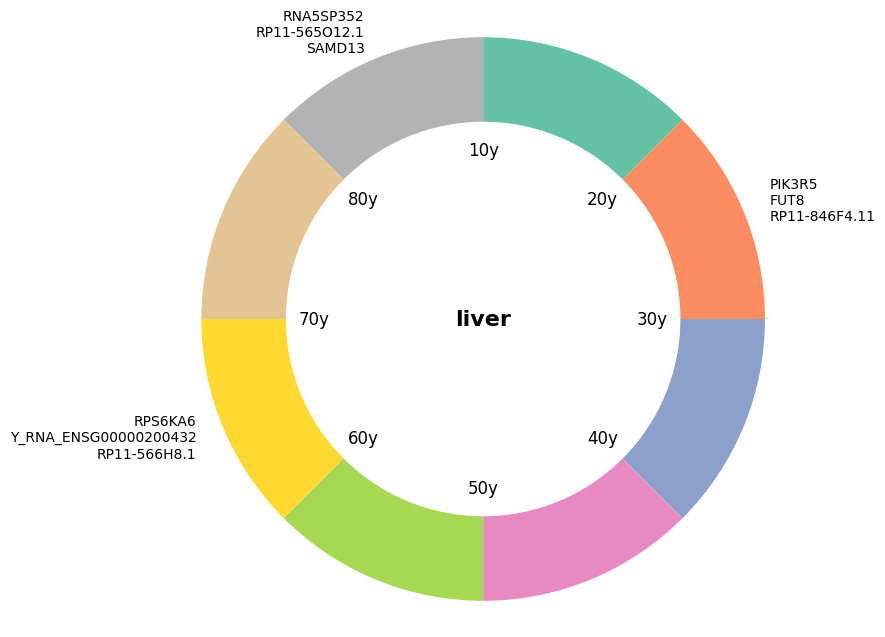

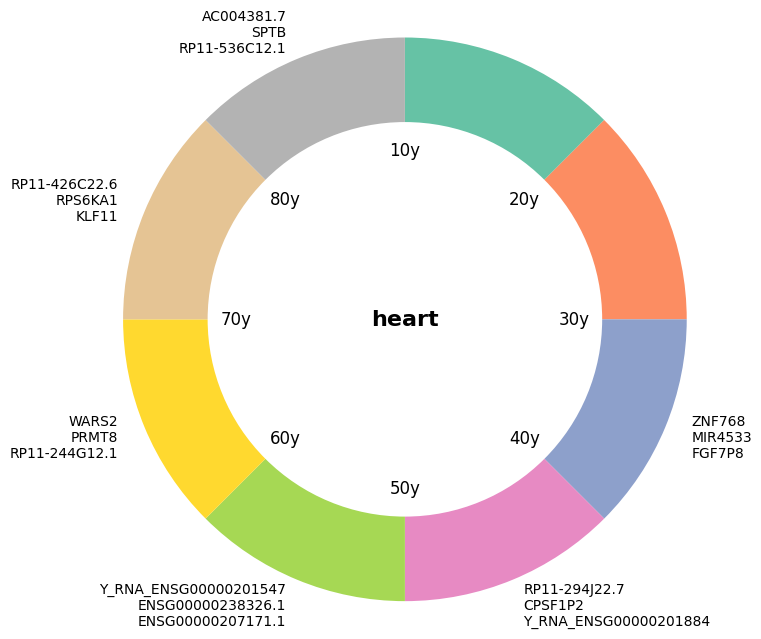

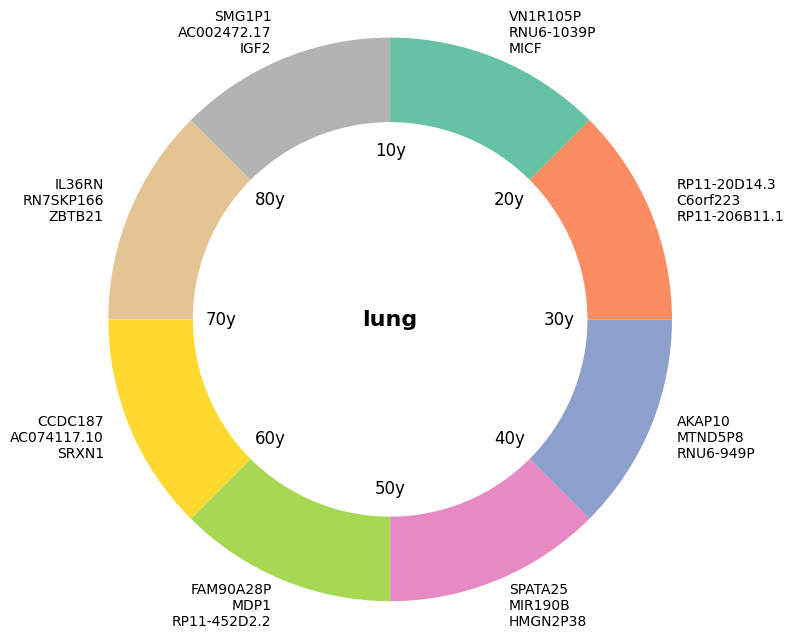

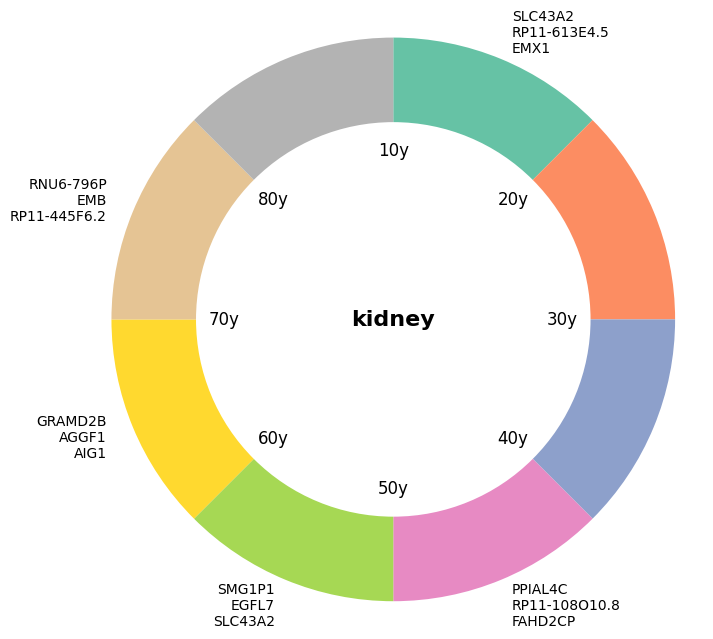

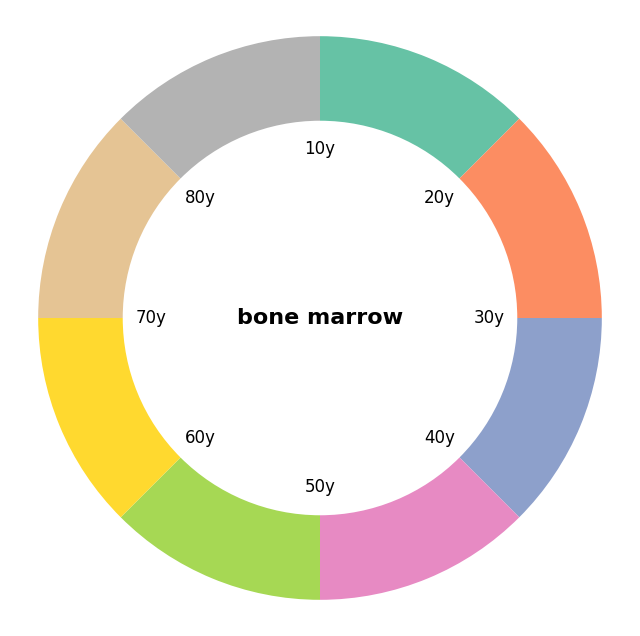

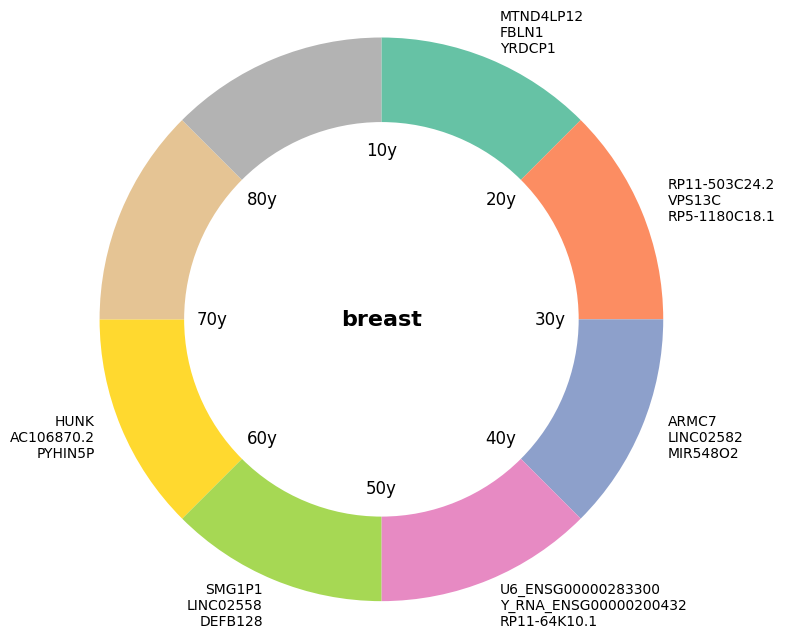

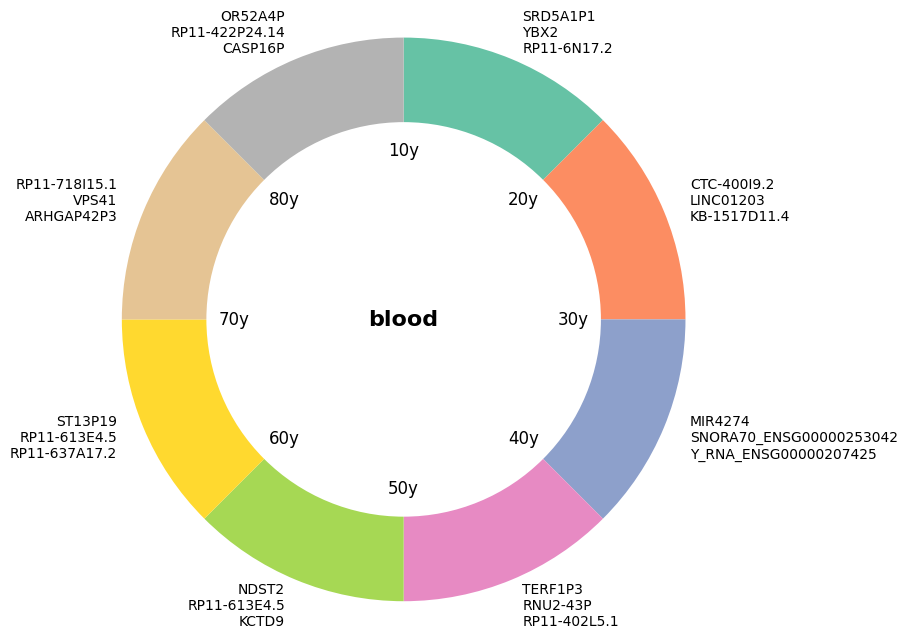

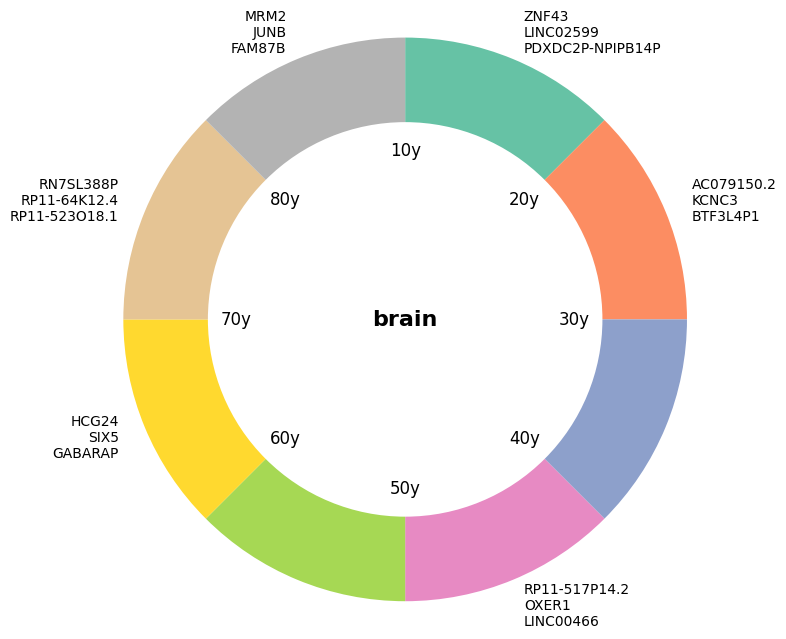

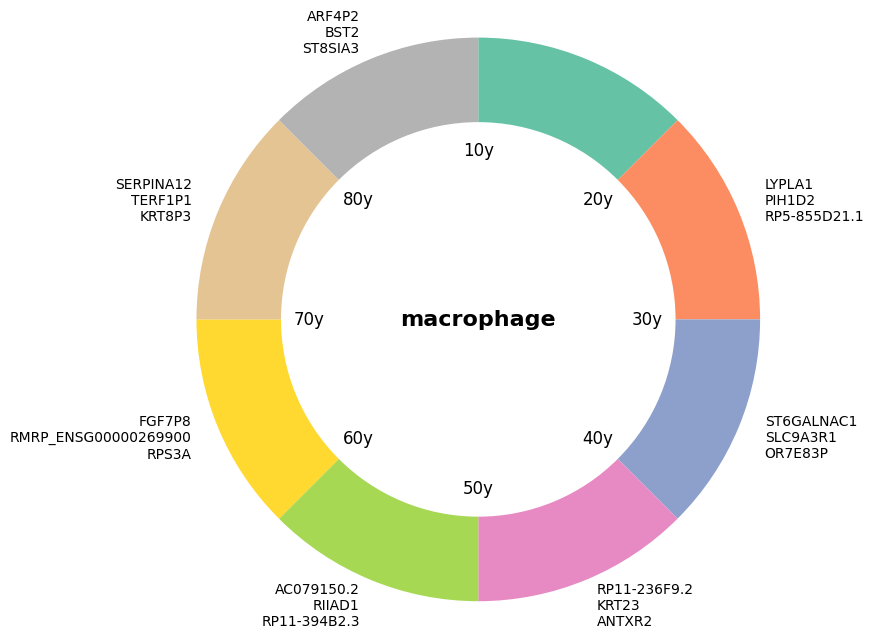

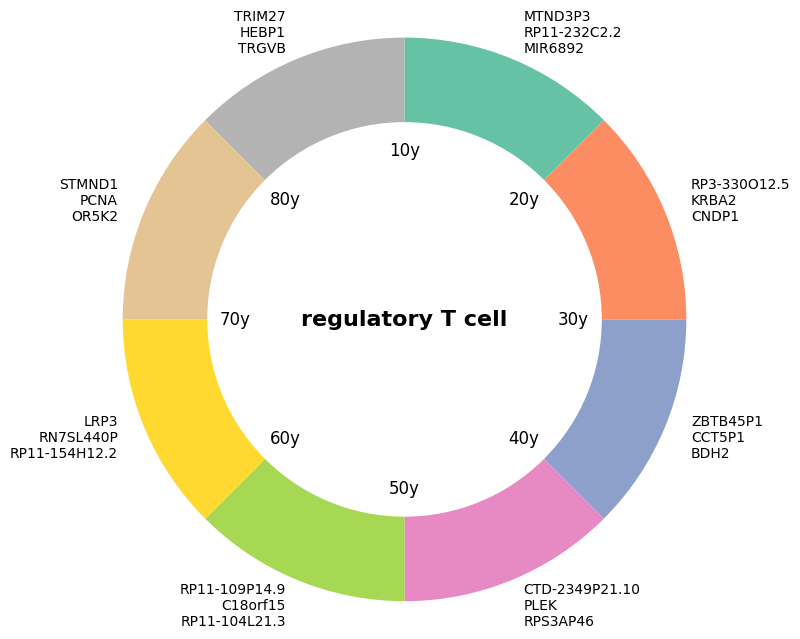

In [32]:
for tissue in ['liver', 'heart','lung', 'kidney',  'bone marrow', 'breast','blood',"brain", 'macrophage', 'regulatory T cell']: # 0.001
    plot_clock_tissue(tissue,tissue_top3genes)

### Fig 7: Temporal drift in gene embedding space during agin

In [33]:
age_label_mapping_20 = {'1-month-old human stage':"unknown",
 '1-year-old human stage':"unknown",
 '10-month-old human stage':"unknown",
 '10-year-old human stage':"<20",
 '10th week post-fertilization human stage':"unknown",
 '11-month-old human stage':"unknown",
 '12-year-old human stage':"<20",
 '12th week post-fertilization human stage':"unknown",
 '13th week post-fertilization human stage':"unknown",
 '14th week post-fertilization human stage':"unknown",
 '15-year-old human stage':"<20",
 '15th week post-fertilization human stage':"unknown",
 '16-year-old human stage':"<20",
 '16th week post-fertilization human stage':"unknown",
 '17-year-old human stage':"<20",
 '17th week post-fertilization human stage':"unknown",
 '18th week post-fertilization human stage':"unknown",
 '19-year-old human stage':"<20",
 '19th week post-fertilization human stage':"unknown",
 '2-5 year-old child stage':"unknown",
 '2-month-old human stage':"unknown",
 '2-year-old human stage':"unknown",
 '20-year-old human stage':"20-40",
 '20th week post-fertilization human stage':"unknown",
 '21-year-old human stage':"20-40",
 '22-year-old human stage':"20-40",
 '23-year-old human stage':"20-40",
 '24-year-old human stage':"20-40",
 '25-year-old human stage':"20-40",
 '25th week post-fertilization human stage':"unknown",
 '26-year-old human stage':"20-40",
 '27-year-old human stage':"20-40",
 '28-year-old human stage':"20-40",
 '29-year-old human stage':"20-40",
 '3-month-old human stage':"unknown",
 '3-year-old human stage':"unknown",
 '30-year-old human stage':"20-40",
 '31-year-old human stage':"20-40",
 '31st week post-fertilization human stage':"unknown",
 '32-year-old human stage':"20-40",
 '33-year-old human stage':"20-40",
 '34-year-old human stage':"20-40",
 '35-year-old human stage':"20-40",
 '36-year-old human stage':"20-40",
 '37-year-old human stage':"20-40",
 '38-year-old human stage':"20-40",
 '39-year-old human stage':"20-40",
 '4-month-old human stage':"unknown",
 '4-year-old human stage':"unknown",
 '40-year-old human stage':"40-60",
 '41-year-old human stage':"40-60",
 '42-year-old human stage':"40-60",
 '43-year-old human stage':"40-60",
 '44-year-old human stage':"40-60",
 '45-year-old human stage':"40-60",
 '46-year-old human stage':"40-60",
 '47-year-old human stage':"40-60",
 '48-year-old human stage':"40-60",
 '49-year-old human stage':"40-60",
 '5-year-old human stage':"unknown",
 '50-year-old human stage':"40-60",
 '51-year-old human stage':"40-60",
 '52-year-old human stage':"40-60",
 '53-year-old human stage':"40-60",
 '54-year-old human stage':"40-60",
 '55-year-old human stage':"40-60",
 '56-year-old human stage':"40-60",
 '57-year-old human stage':"40-60",
 '58-year-old human stage':"40-60",
 '59-year-old human stage':"40-60",
 '6-12 year-old child stage':"unknown",
 '6-month-old human stage':"unknown",
 '6-year-old human stage':"unknown",
 '60-year-old human stage':"60-80",
 '61-year-old human stage':"60-80",
 '62-year-old human stage':"60-80",
 '63-year-old human stage':"60-80",
 '64-year-old human stage':"60-80",
 '65-year-old human stage':"60-80",
 '66-year-old human stage':"60-80",
 '67-year-old human stage':"60-80",
 '68-year-old human stage':"60-80",
 '69-year-old human stage':"60-80",
 '7-month-old human stage':"unknown",
 '7-year-old human stage':"unknown",
 '70-year-old human stage':"60-80",
 '71-year-old human stage':"60-80",
 '72-year-old human stage':"60-80",
 '73-year-old human stage':"60-80",
 '74-year-old human stage':"60-80",
 '75-year-old human stage':"60-80",
 '76-year-old human stage':"60-80",
 '77-year-old human stage':"60-80",
 '78-year-old human stage':"60-80",
 '79-year-old human stage':"60-80",
 '8-year-old human stage':"unknown",
 '80 year-old and over human stage':">80",
 '80-year-old human stage':">80",
 '81-year-old human stage':">80",
 '82-year-old human stage':">80",
 '83-year-old human stage':">80",
 '84-year-old human stage':">80",
 '85-year-old human stage':">80",
 '86-year-old human stage':">80",
 '87-year-old human stage':">80",
 '88-year-old human stage':">80",
 '89-year-old human stage':">80",
 '9-month-old human stage':"unknown",
 '9-year-old human stage':"unknown",
 '90-year-old human stage':">80",
 '92-year-old human stage':">80",
 '9th week post-fertilization human stage':"unknown",
 'Carnegie stage 17':"unknown",
 'Carnegie stage 18':"unknown",
 'Carnegie stage 20':"unknown",
 'Carnegie stage 22':"unknown",
 'Carnegie stage 23':"unknown",
 'adolescent stage':"unknown",
 'eighth LMP month human stage':"unknown",
 'eighth decade human stage':">80",
 'embryonic human stage':"unknown",
 'fifth LMP month human stage':"unknown",
 'fifth decade human stage':"40-60",
 'fourth decade human stage':"40-60",
 'human adult stage':"unknown",
 'human aged stage':"unknown",
 'infant stage':"unknown",
 'mature stage':"unknown",
 'newborn human stage':"unknown",
 'ninth decade human stage':">80",
 'organogenesis stage':"unknown",
 'seventh decade human stage':"60-80",
 'sixth decade human stage':"60-80",
 'third decade human stage':"20-40",
 'unknown':"unknown",
 'young adult stage':"unknown"}

In [34]:
def adata2cos_gene(adata, gene, age_map = age_label_mapping_20, reference="<20", normal=True):
    if normal:
        adata = adata[(adata.obs[f'{gene}_embedding_status'] == "present") & (adata.obs["disease"] == "normal")]
    else:
        adata = adata[(adata.obs[f'{gene}_embedding_status'] == "present") & (adata.obs["disease"] != "normal")]
    adata.obs["age_group"] = adata.obs["development_stage"].map(age_map)
    adata = adata[~adata.obs["age_group"].isin(["unknown"])]
    embeddings = adata.obsm[f'{gene}_embeddings'] 
    age_groups = adata.obs['age_group']
    reference_embeddings = embeddings[age_groups == reference]

    if len(reference_embeddings) == 0:
        print(f"no embedding left for {gene}")
        return

    cos_sim_results = {}  

    for i in range(len(adata)):
        current_age_range = adata[i].obs["age_group"].item()
        current_cell_embedding = embeddings[i].reshape(1, -1) 
        cos_sim = cosine_similarity(current_cell_embedding, reference_embeddings).mean()
        if current_age_range not in cos_sim_results:
            cos_sim_results[current_age_range] = [cos_sim]
        else:
            cos_sim_results[current_age_range].append(cos_sim)
    return cos_sim_results

In [35]:
gene_functions = {
    "ATR": "DNA Repair", #same
    "TDP2": "DNA Repair", #up
    "SAFB2": "Stress Response", #up
    "HERPUD1": "Stress Response", #down
    "MCTP1": "Oxidative Stress", #up
    "HEBP2": "Oxidative Stress", #down
    "SESN1": "Oxidative Stress", #same
    "APC": "Tumor Suppressor", #up
    "MKRN1": "Tumor Suppressor",  #same
    "BANP": "Tumor Suppressor", #down
    "IFITM3":"Immune Response"
}
function_colors = {
    "DNA Repair": "purple",
    "Stress Response": "teal",
    "Oxidative Stress": "orange",
    "Tumor Suppressor": "red",
    "Immune Response":"blue"
}
age_order = ["<20", "20-40", "40-60", "60-80", ">80"]

In [37]:
all_genes_data_variance = []
all_genes_data = []
selected_genes = gene_functions.keys()
gene_embeddings = {}

for gene in selected_genes:
    cosine_similarity_data = adata2cos_gene(adata, gene)
    if cosine_similarity_data is not None:
        # Calculate mean similarity values adjusted by the mean of the <20 group
        mean_under_20 = sum(cosine_similarity_data['<20']) / len(cosine_similarity_data['<20'])
        for label, values in cosine_similarity_data.items():
            for value in values:
                all_genes_data_variance.append({
                    "Gene": gene,
                    "Function": gene_functions[gene],
                    "Age Group": label,
                    "Cosine Similarity": value - mean_under_20
                })
            all_genes_data.append({
                    "Gene": gene,
                    "Function": gene_functions[gene],
                    "Age Group": label,
                    "Cosine Similarity": np.mean(values) - mean_under_20
                })
        gene_embeddings[gene] = cosine_similarity_data
            
df_variance = pd.DataFrame(all_genes_data_variance)
age_group_order = ["<20", "20-40", "40-60", "60-80", ">80"]
df_variance['Age Group'] = pd.Categorical(df_variance['Age Group'], categories=age_group_order, ordered=True)

df = pd.DataFrame(all_genes_data)
age_group_order = ["<20", "20-40", "40-60", "60-80", ">80"]
df['Age Group'] = pd.Categorical(df['Age Group'], categories=age_group_order, ordered=True)


/tmp/ipykernel_5352/2606811974.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["age_group"] = adata.obs["development_stage"].map(age_map)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_5352/2606811974.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["age_group"] = adata.obs["development_stage"].map(age_map)
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_5352/2606811974.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["age

In [9]:
df.to_csv("df_gene_variance2youngest.csv")

In [10]:
df_variance.to_csv("df_gene_variance2youngest_with_variance.csv")

In [11]:
def p_2_sign(p):
    """Convert p-value to significance markers."""
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

In [12]:
from scipy.stats import ttest_ind
p_values = {}
for gene, lst in gene_embeddings.items():
    list2 = lst["<20"]
    p_values[gene] = {}
    for age_group, values in lst.items():
        if age_group != "<20":
            t_stat, p_value = ttest_ind(values, list2, equal_var=False)
            p_values[gene][age_group] = p_value
p_values

{'ATR': {'20-40': 0.005346426769747739,
  '>80': 0.08157970115785916,
  '40-60': 0.047125965556111225,
  '60-80': 6.810014147614084e-07},
 'TDP2': {'>80': 0.9695424951763072,
  '20-40': 0.3582358122556015,
  '40-60': 0.41217653455794867,
  '60-80': 0.11991255288631626},
 'SAFB2': {'20-40': 0.9949235396644862,
  '40-60': 0.8638875479896881,
  '>80': 0.5401801552563801,
  '60-80': 0.7366236528495813},
 'HERPUD1': {'>80': 0.09344009916469678,
  '20-40': 2.3532507639058208e-05,
  '40-60': 0.004328379538268235,
  '60-80': 2.4193192539771294e-12},
 'MCTP1': {'20-40': 1.809274035785612e-09,
  '>80': 9.234801844869454e-07,
  '40-60': 3.1538015099664685e-08,
  '60-80': 1.1256733184990608e-12},
 'HEBP2': {'40-60': 1.0710172632042005e-59,
  '20-40': 3.664685400720103e-49,
  '>80': 5.688527179835386e-39,
  '60-80': 8.307764724939237e-35},
 'SESN1': {'20-40': 0.002424591886321682,
  '>80': 0.008863498848523173,
  '60-80': 5.4363439984059346e-08,
  '40-60': 0.005406327505421794},
 'APC': {'20-40': 0

In [ ]:
for gene in df_variance['Gene'].unique():
    # Filter the data for the current gene
    gene_data = df_variance[df_variance['Gene'] == gene]
    
    # Create a line plot for the current gene
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=gene_data, x="Age Group", y="Cosine Similarity", marker='o')
    
    # Set x-axis tick labels
    plt.xticks(range(len(age_group_order)), age_group_order, rotation=45, fontsize=12)
    
    # Add significance markers if available
    if gene in p_values:
        for age_group, p_val in p_values[gene].items():
            if age_group in age_group_order:
                x_pos = age_group_order.index(age_group)  # Get the x-axis position
                y_pos = 0.05#gene_data['Cosine Similarity'].max() * 0.95 # Place above the max y-value
                plt.text(x_pos, y_pos, p_2_sign(p_val), 
                         ha='center', va='center', fontsize=14, color='black')
    
    # Add title, labels, and adjust layout
    plt.title(f"cosine similarity changes to <20 for {gene}", fontsize=20)
    plt.ylim((-0.5,0.1))
    plt.xlabel('age group', fontsize=16)
    plt.ylabel('cosine similarity', fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.savefig('plots/compare2<20_withP.png', dpi=300, bbox_inches='tight')

### Figure 8: Conservative genes

In [ ]:
adata.obs["age_group"] = adata.obs["development_stage"].map(age_label_mapping_20)
for gene1 in all_genes:
    for gene2 in all_genes:
        if gene2 != gene1:
        # List of age groups to compare
            age_groups = ['<20', '20-40', '40-60', '60-80', '>80']

            # Initialize a list to store results
            cosine_similarities = []

            # Loop through each age group and compute cosine similarity between the two genes
            for age_group in age_groups:
                # Filter cells that belong to the current age group and have valid embeddings for both genes
                
                age_group_cells = adata[adata.obs['age_group'] == age_group]
                
                if all(f'{gene}_embedding_status' in age_group_cells.obs.columns for gene in [gene1, gene2]):
                    # Get the embeddings for both genes
                    gene1_embeddings = age_group_cells.obsm[f'{gene1}_embeddings']
                    gene2_embeddings = age_group_cells.obsm[f'{gene2}_embeddings']
                    
                    # Ensure there are valid embeddings
                    valid_cells_gene1 = age_group_cells[age_group_cells.obs[f'{gene1}_embedding_status'] == 'present']
                    valid_cells_gene2 = age_group_cells[age_group_cells.obs[f'{gene2}_embedding_status'] == 'present']
                    
                    if valid_cells_gene1.n_obs > 0 and valid_cells_gene2.n_obs > 0:
                        # Calculate cosine similarity between the two gene embeddings
                        cos_sim = cosine_similarity(gene1_embeddings, gene2_embeddings).mean()
                        
                        # Append the result
                        cosine_similarities.append({
                            'age_group': age_group,
                            'cosine_similarity': cos_sim
                        })

            # Convert to DataFrame for easier plotting
            cosine_sim_df = pd.DataFrame(cosine_similarities)

            # Plot the results
            plt.figure(figsize=(10, 6))
            plt.plot(cosine_sim_df['age_group'], cosine_sim_df['cosine_similarity'], marker='o', linestyle='-', color='b', label=f'{gene1} vs {gene2}')
            plt.xlabel('Age Group')
            plt.ylabel('Cosine Similarity')
            plt.title(f'Cosine Similarity Between {gene1} and {gene2} Across Age Groups')
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            #plt.show()
            plt.savefig(f"output/{gene1}_{gene2}.png")
            plt.close()

In [ ]:
def adata2cos_gene_age(adata, gene, age_map = age_label_mapping_20, normal = True):
    if normal:
        adata = adata[(adata.obs[f'{gene}_embedding_status'] == "present") & (adata.obs["disease"] == "normal")]
    else:
        adata = adata[(adata.obs[f'{gene}_embedding_status'] == "present") & (adata.obs["disease"] != "normal")]
    adata.obs["age_group"] = adata.obs["development_stage"].map(age_map).to_list()
    adata = adata[~adata.obs["age_group"].isin(["unknown"])]
    embeddings = adata.obsm[f'{gene}_embeddings']
    cos_sim_results = {}  # To handle cases where no similarity can be computed

    # Iterate through every single cell in adata
    for i in range(len(adata)):
        reference_embeddings = adata[i].obsm['development_stage_embeddings']
        current_age_range = adata[i].obs["age_group"].item()
        current_cell_embedding = embeddings[i].reshape(1, -1)  # Reshape to match dimensions for cosine_similarity
        
        cos_sim = cosine_similarity(current_cell_embedding, reference_embeddings).mean()

        # Store the computed similarity for the current cell
        if current_age_range not in cos_sim_results:
            cos_sim_results[current_age_range] = [cos_sim]
        else:
            cos_sim_results[current_age_range].append(cos_sim)
    return cos_sim_results

In [19]:
all_genes_data_variance = []
all_genes_data = []
selected_genes = gene_functions.keys()

for gene in selected_genes:
    cosine_similarity_data = adata2cos_gene_age(adata, gene)
    if cosine_similarity_data is not None:
        # Calculate mean similarity values adjusted by the mean of the <20 group
        mean_under_20 = sum(cosine_similarity_data['<20']) / len(cosine_similarity_data['<20'])
        for label, values in cosine_similarity_data.items():
            for value in values:
                all_genes_data_variance.append({
                    "Gene": gene,
                    "Function": gene_functions[gene],
                    "Age Group": label,
                    "Cosine Similarity": value# - mean_under_20
                })
            all_genes_data.append({
                    "Gene": gene,
                    "Function": gene_functions[gene],
                    "Age Group": label,
                    "Cosine Similarity": np.mean(values)# - mean_under_20
                })
            
df_variance = pd.DataFrame(all_genes_data_variance)
age_group_order = ["<20", "20-40", "40-60", "60-80", ">80"]
df_variance['Age Group'] = pd.Categorical(df_variance['Age Group'], categories=age_group_order, ordered=True)

df = pd.DataFrame(all_genes_data)
age_group_order = ["<20", "20-40", "40-60", "60-80", ">80"]
df['Age Group'] = pd.Categorical(df['Age Group'], categories=age_group_order, ordered=True)

/tmp/ipykernel_5352/2689555536.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["age_group"] = adata.obs["development_stage"].map(age_map).to_list()
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_5352/2689555536.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["age_group"] = adata.obs["development_stage"].map(age_map).to_list()
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make t

In [10]:
healthy_genes_data_variance = []
healthy_genes_data = []
unhealthy_genes_data_variance = []
unhealthy_genes_data = []
selected_genes = gene_functions.keys()

for gene in selected_genes:
    cosine_similarity_data = adata2cos_gene_age(adata, gene)
    if cosine_similarity_data is not None:
        # Calculate mean similarity values adjusted by the mean of the <20 group
        #mean_under_20 = sum(cosine_similarity_data['<20']) / len(cosine_similarity_data['<20'])
        for label, values in cosine_similarity_data.items():
            for value in values:
                healthy_genes_data_variance.append({
                    "Gene": gene,
                    "Function": gene_functions[gene],
                    "Age Group": label,
                    "Cosine Similarity": value#- mean_under_20
                })
            healthy_genes_data.append({
                    "Gene": gene,
                    "Function": gene_functions[gene],
                    "Age Group": label,
                    "Cosine Similarity": np.mean(values)# - mean_under_20
                })
    cosine_similarity_data = adata2cos_gene_age(adata, gene, normal=False)
    if cosine_similarity_data is not None:
        #mean_under_20 = sum(cosine_similarity_data['<20']) / len(cosine_similarity_data['<20'])
        for label, values in cosine_similarity_data.items():
            for value in values:
                unhealthy_genes_data_variance.append({
                    "Gene": gene,
                    "Function": gene_functions[gene],
                    "Age Group": label,
                    "Cosine Similarity": value #- mean_under_20
                })
            unhealthy_genes_data.append({
                    "Gene": gene,
                    "Function": gene_functions[gene],
                    "Age Group": label,
                    "Cosine Similarity": np.mean(values)# - mean_under_20
                })
            
df_variance_healthy = pd.DataFrame(healthy_genes_data_variance)
age_group_order = ["<20", "20-40", "40-60", "60-80", ">80"]
df_variance_healthy['Age Group'] = pd.Categorical(df_variance_healthy['Age Group'], categories=age_group_order, ordered=True)

df_healthy = pd.DataFrame(healthy_genes_data)
age_group_order = ["<20", "20-40", "40-60", "60-80", ">80"]
df_healthy['Age Group'] = pd.Categorical(df_healthy['Age Group'], categories=age_group_order, ordered=True)

df_variance_unhealthy = pd.DataFrame(unhealthy_genes_data_variance)
age_group_order = ["<20", "20-40", "40-60", "60-80", ">80"]
df_variance_unhealthy['Age Group'] = pd.Categorical(df_variance_unhealthy['Age Group'], categories=age_group_order, ordered=True)

df_unhealthy = pd.DataFrame(unhealthy_genes_data)
age_group_order = ["<20", "20-40", "40-60", "60-80", ">80"]
df_unhealthy['Age Group'] = pd.Categorical(df_unhealthy['Age Group'], categories=age_group_order, ordered=True)

/tmp/ipykernel_5352/2689555536.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["age_group"] = adata.obs["development_stage"].map(age_map).to_list()
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_5352/2689555536.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["age_group"] = adata.obs["development_stage"].map(age_map).to_list()
/home/yufan/.venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make t

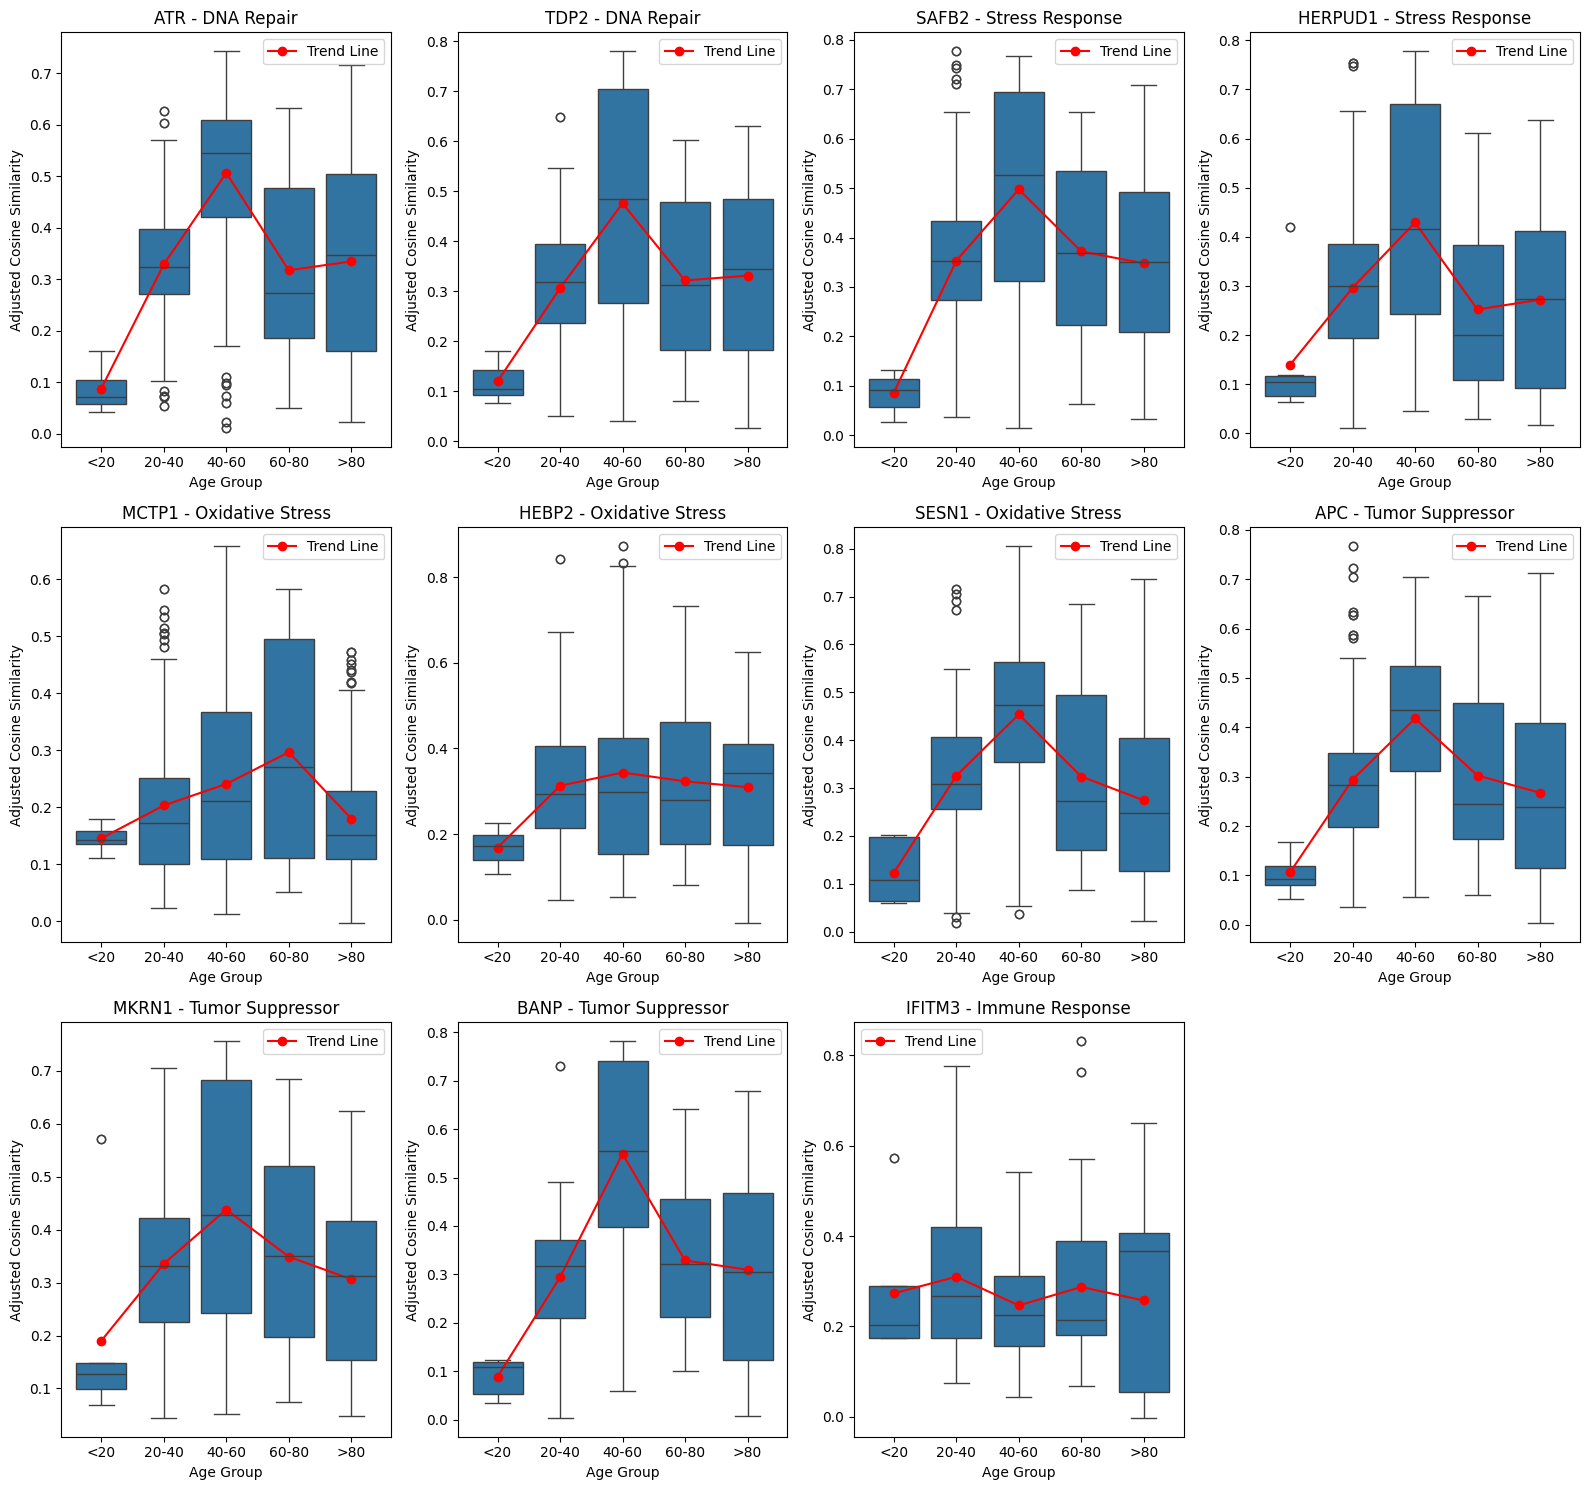

In [12]:
genes = df_healthy['Gene'].unique()

# Set up a single large figure with subplots
num_genes = len(genes)
cols = 4  # Number of columns
rows = (num_genes + cols - 1) // cols  # Calculate number of rows
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 5 * rows))

# Flatten axes for easy iteration if there are multiple rows and columns
axes = axes.flatten()

for i, (ax, gene) in enumerate(zip(axes, genes)):
    # Filter data for the current gene
    gene_data = df_healthy[df_healthy['Gene'] == gene].sort_values(by="Age Group")  # Sort by age group
    gene_variance_data = df_variance_healthy[df_variance_healthy['Gene'] == gene].sort_values(by="Age Group")  # Sort by age group
    
    # Plot boxplot
    sns.boxplot(
        x="Age Group",
        y="Cosine Similarity",
        data=gene_variance_data,
        ax=ax,
    )
    
    # Fit and plot a linear trend line
    ax.plot(
        gene_data['Age Group'],
        gene_data['Cosine Similarity'],
        marker='o',
        color='r',
        label="Trend Line",
    )
    
    # Customize the subplot
    ax.set_title(f"{gene} - {gene_data['Function'].iloc[0]}")
    ax.set_xlabel("Age Group")
    ax.set_ylabel("Adjusted Cosine Similarity")
    ax.legend()

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Tight layout and show plot
plt.tight_layout()
plt.show()


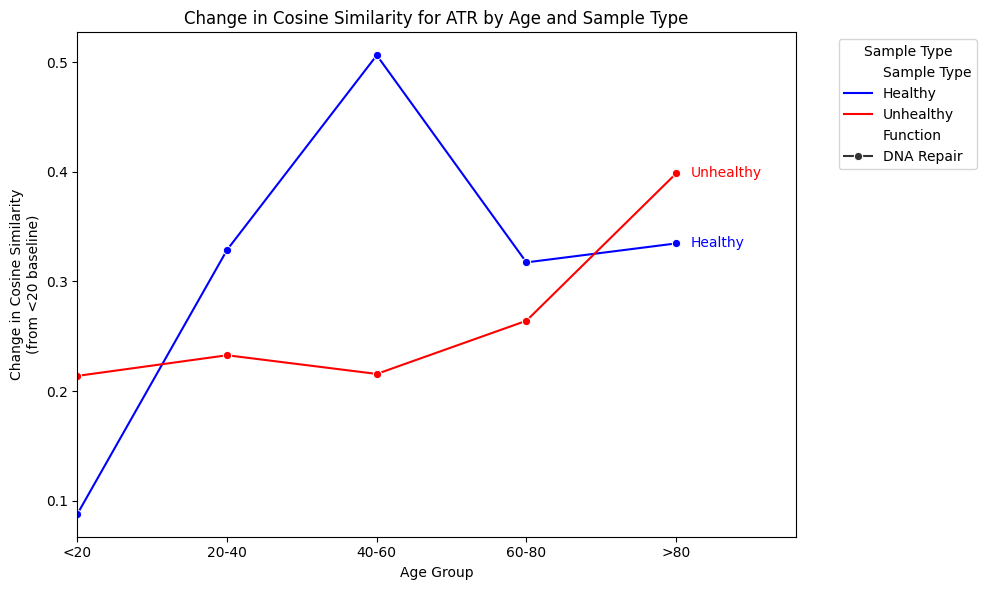

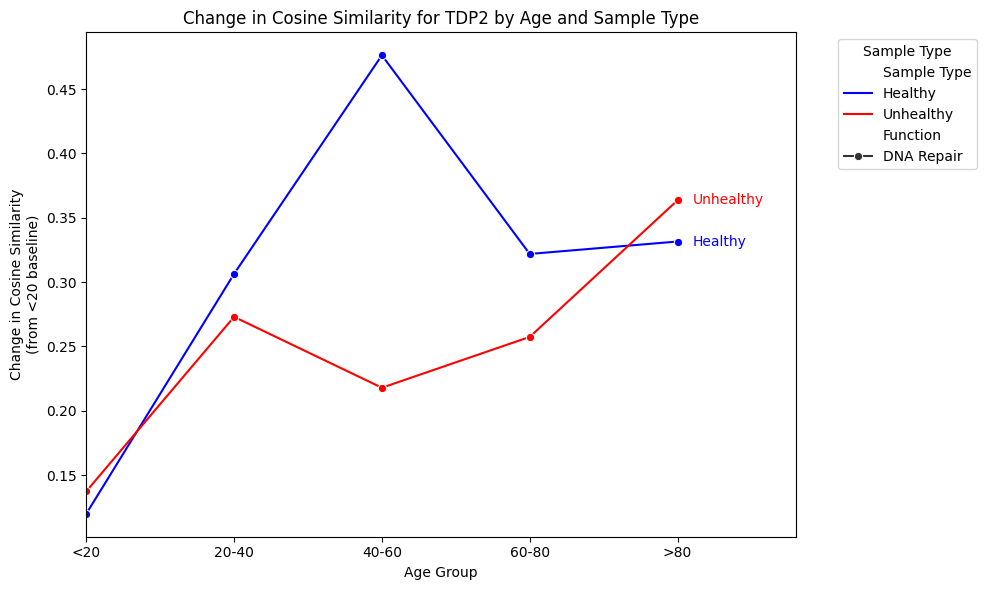

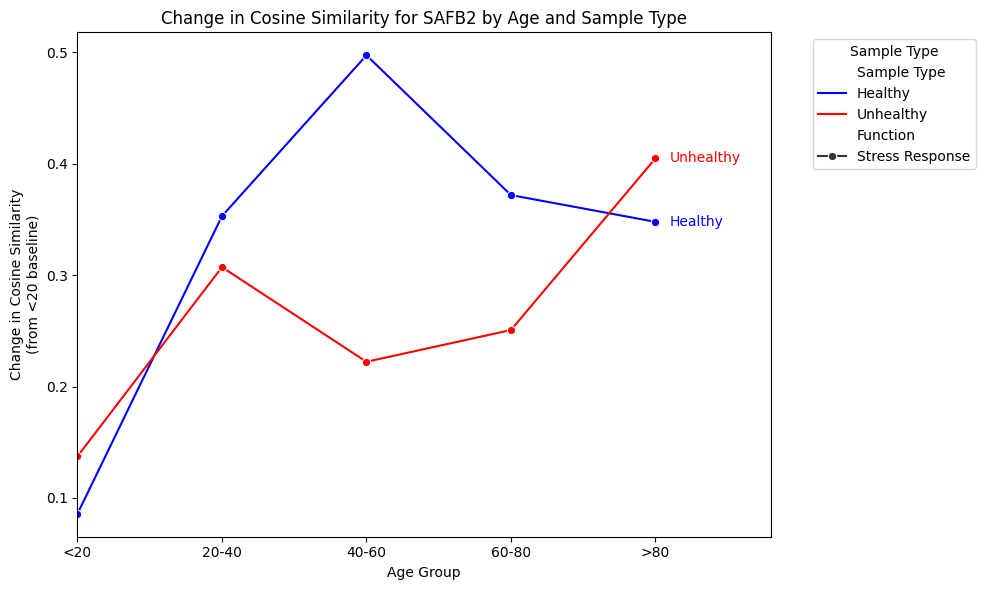

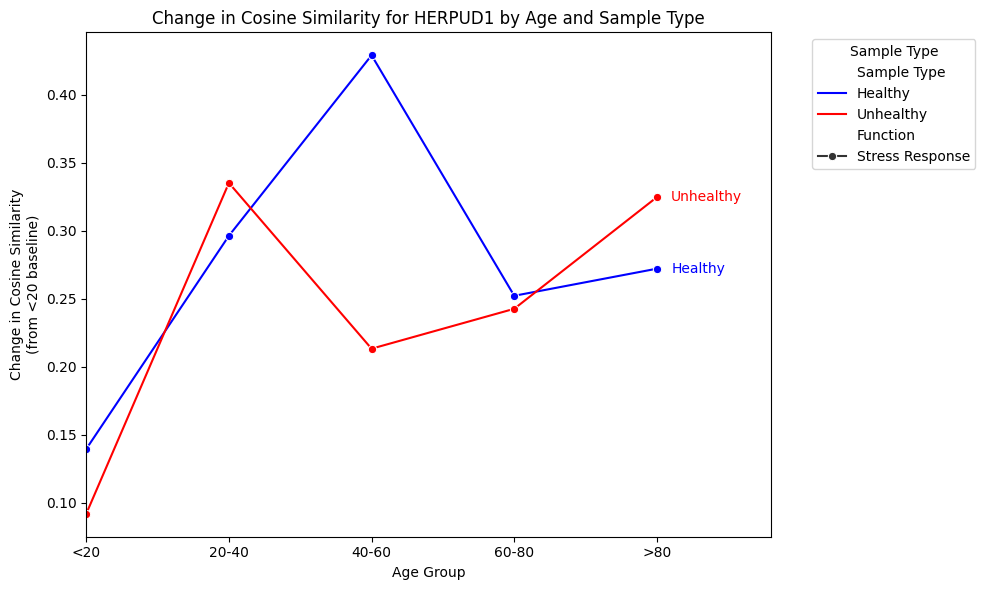

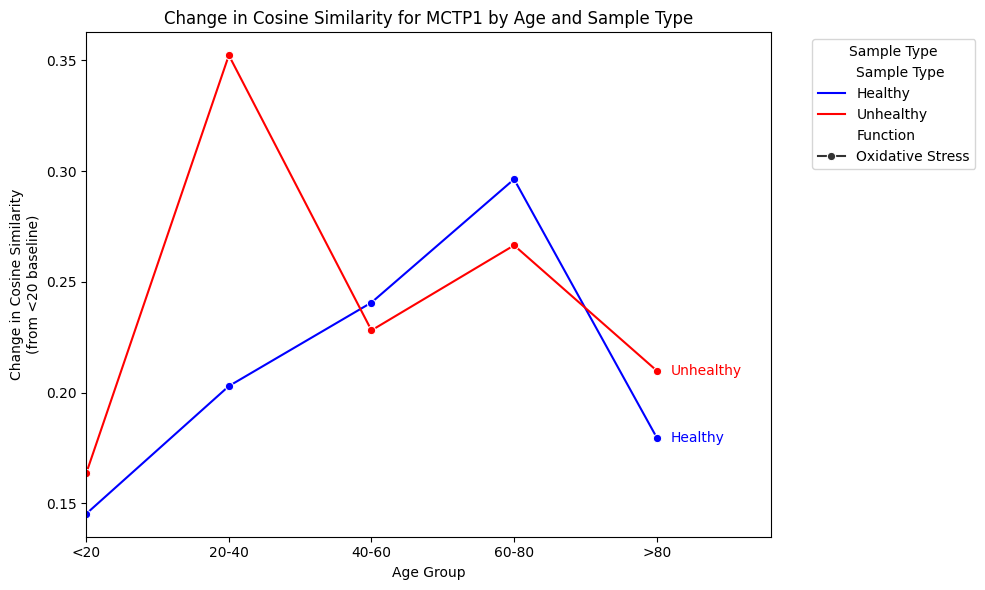

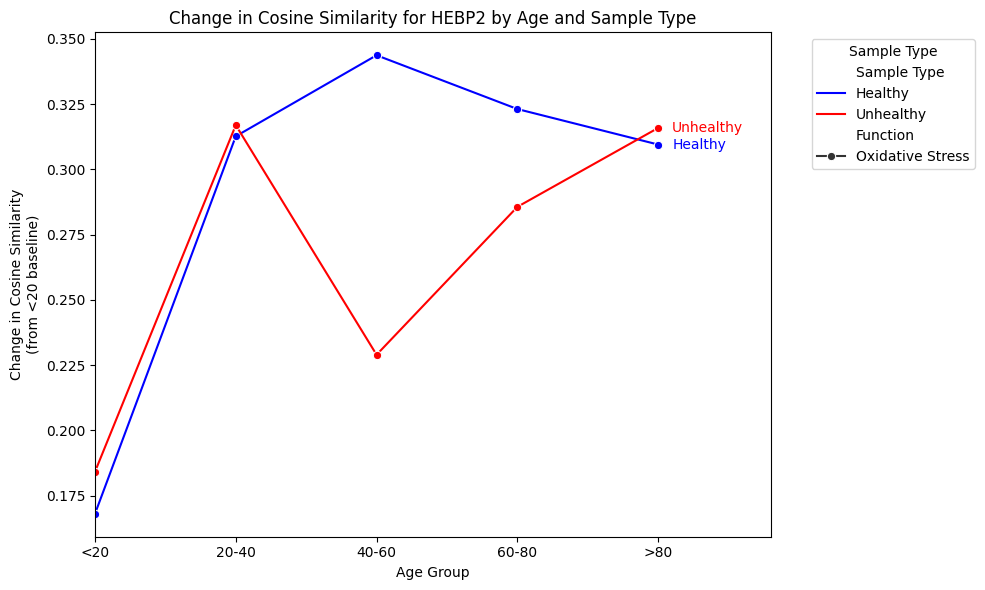

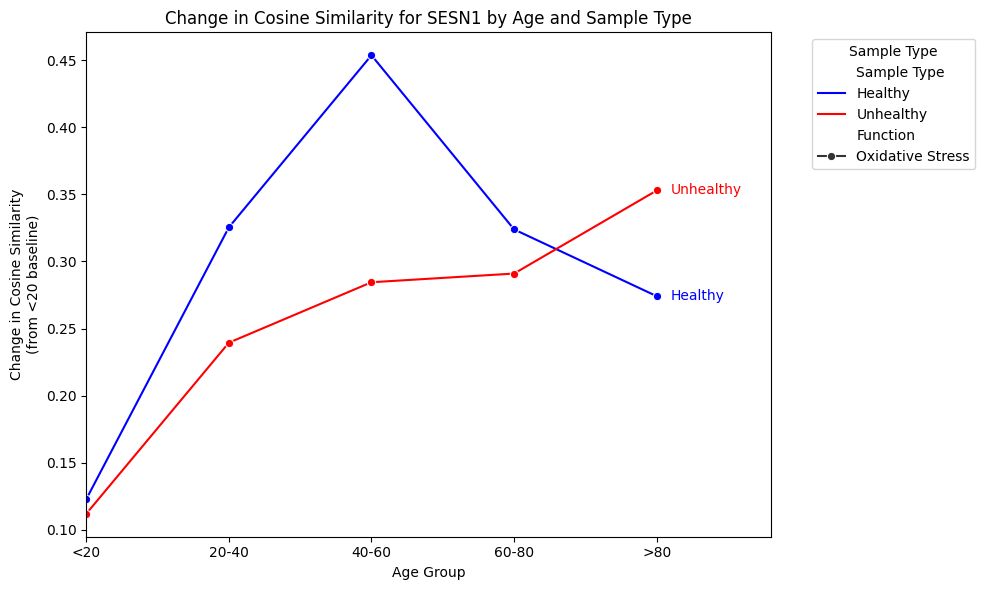

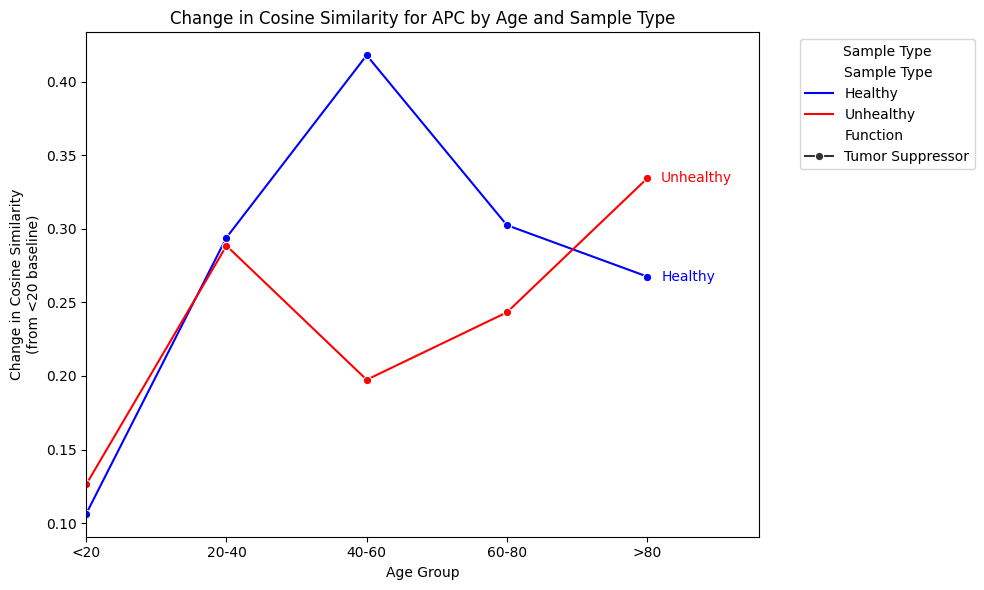

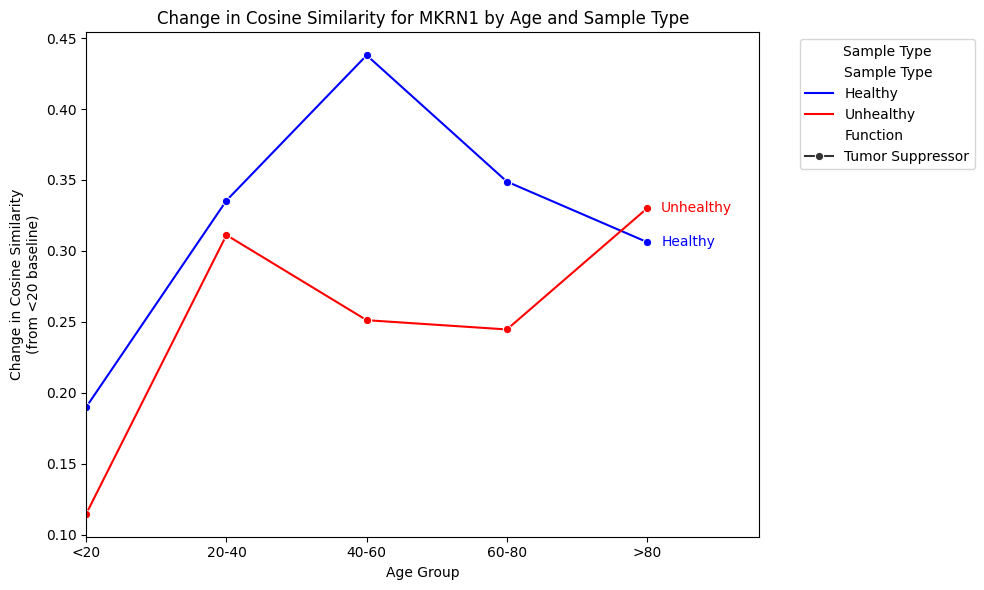

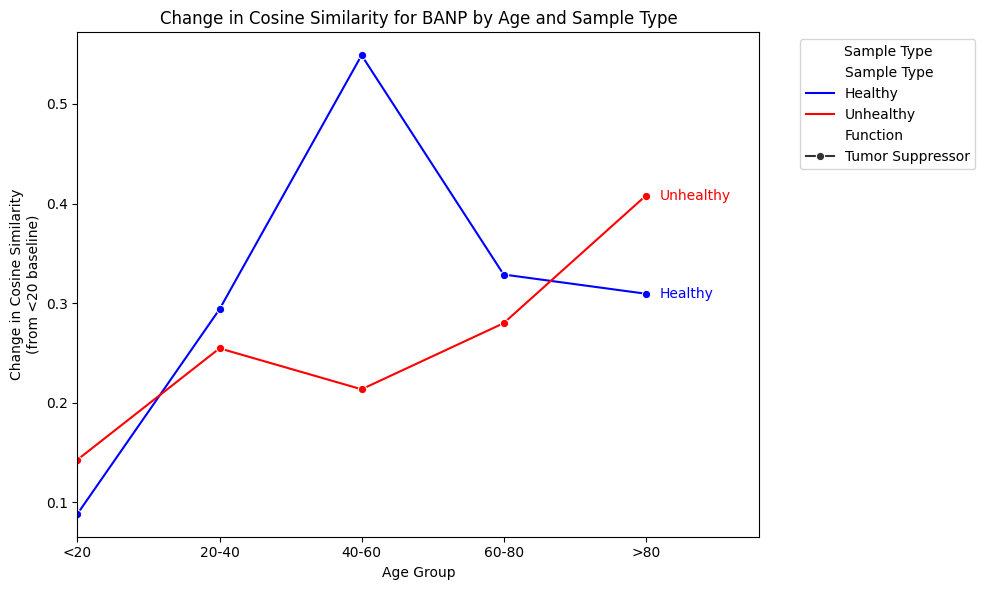

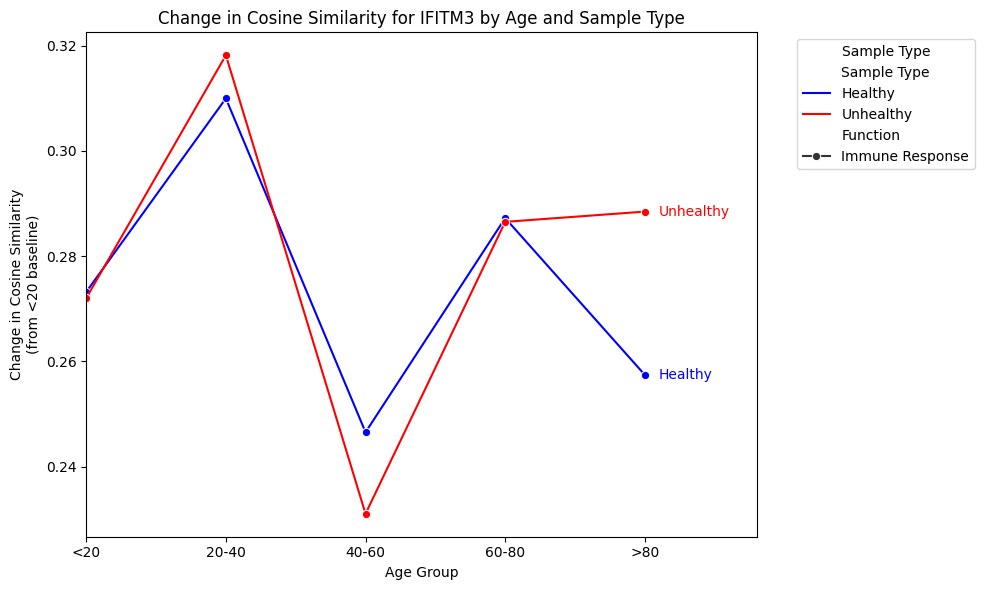

In [13]:
df_healthy['Sample Type'] = 'Healthy'
df_unhealthy['Sample Type'] = 'Unhealthy'
df_combined = pd.concat([df_healthy, df_unhealthy], axis=0)

# Custom color palette
function_colors = {"Function1": "blue", "Function2": "orange", "Function3": "green"}  # Example

# Loop through each gene and create a separate plot
for gene in df_combined['Gene'].unique():
    # Filter the data for the current gene
    gene_data = df_combined[df_combined['Gene'] == gene]
    
    # Create the figure
    plt.figure(figsize=(10, 6))

    # Create the line plot with healthy and unhealthy data
    sns.lineplot(
        data=gene_data,
        x="Age Group",
        y="Cosine Similarity",
        hue="Sample Type",  # Distinguish between healthy and unhealthy
        style="Function",  # Different styles for each function
        markers=True,
        palette={"Healthy": "blue", "Unhealthy": "red"},  # Custom colors for healthy and unhealthy
    )

    # Set axis labels and title
    plt.xlabel("Age Group")
    plt.ylabel("Change in Cosine Similarity\n(from <20 baseline)")
    plt.title(f"Change in Cosine Similarity for {gene} by Age and Sample Type")

    # Set x-axis limits and add some space on the right for gene labels
    plt.xlim(0, 4.8)

    # Add function labels on the right side of the plot
    for sample_type, color in zip(["Healthy", "Unhealthy"], ["blue", "red"]):
        sample_data = gene_data[gene_data["Sample Type"] == sample_type]
        if len(sample_data) > 0:
            last_age = ">80"  # Last age group to place label
            last_value = sample_data[sample_data['Age Group'] == last_age]["Cosine Similarity"].values[0]
            plt.text(4.1, last_value, sample_type, color=color, verticalalignment='center')

    # Adjust the legend position
    plt.legend(title="Sample Type", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Set x-axis tick labels
    age_order = ['<20', '20-40', '40-60', '60-80', '>80']  # Adjust as necessary
    plt.xticks(range(len(age_order)), age_order)

    # Optimize layout and save plot
    plt.tight_layout()
    plt.show()
    #plt.savefig(f"output/{gene}_cosine_similarity.png")
    #plt.close()  # Close the figure to save memory